In [1]:
from IPython.core.display import display, HTML

import pandas as pd
import numpy as np # linear algebra
import glob
import os
import gc
import pickle

from joblib import Parallel, delayed

from sklearn import preprocessing, model_selection
import lightgbm as lgb

from sklearn.metrics import r2_score

import matplotlib.pyplot as plt 
import seaborn as sns

from scipy.stats import binned_statistic

from functools import partial
from numba import jit

# import tensorflow as tf 
# from tensorflow import keras
# from keras import layers

path_root = '../input/optiver-realized-volatility-prediction'
#path_data = '../input/optiver-realized-volatility-prediction'
path_data = '/home/optimusprime/Desktop/peeterson/optiver/Optiver-Realized-Volatility-Prediction/data'
path_submissions = '/'

target_name = 'target'
scores_folds = {}

/tmp/ipykernel_5797/2640917597.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Time Binned Data Gen

In [2]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

def diff(list_stock_prices):
    return list_stock_prices.diff() 

def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

def realized_absvol(series_log_return):
    return np.sum(np.abs(series_log_return))

@jit(nopython=True)
def finish_bin(bin_width, bin_sum:float, bin_weight:float, last_val, last_weight, last_time)->float: 
    dt = bin_width - last_time%bin_width
    
    bin_weight += 1.0*last_weight*dt
    bin_sum    += 1.0*last_weight*dt*last_val
    
    return float(bin_sum/(bin_weight + 1e-8))
    
import typing



@jit()
def binned_time_weighted_mean_stat(t, tid, x, w, bin_width, n_bins, n_rows):
    #bin_list = [[]]
    z = np.zeros( (n_rows,n_bins) )
    
    prev_time   = 0
    prev_weight = 0.0
    prev_val    = 0.0
    
    bin_sum = 0.0
    bin_weight = 0.0

    zk  = 0
    zkk = 0
    for k in range(t.shape[0]):
        
        if tid[k] != tid[max(k-1,0)]:
            z[zk, zkk] = float(finish_bin(bin_width, bin_sum, bin_weight, prev_val, prev_weight, prev_time))
            zkk += 1
            
            while zkk < z.shape[1]:
                z[zk, zkk] = prev_val
                zkk += 1
            zk += 1
            zkk = 0
            
            prev_time  = 0
            bin_sum    = 0.0
            bin_weight = 0.0            
            
        if int(t[k]//bin_width) != int(prev_time//bin_width):
            
            z[zk, zkk] = float(finish_bin(bin_width, bin_sum, bin_weight, prev_val, prev_weight, prev_time))
            zkk += 1
            
            while zkk < t[k]//bin_width:
                z[zk, zkk] = prev_val
                zkk += 1
            
            prev_time  = bin_width*(t[k]//bin_width)
            bin_sum    = 0.0
            bin_weight = 0.0
        
        bin_sum    += prev_val*prev_weight*(t[k] - prev_time)
        bin_weight +=          prev_weight*(t[k] - prev_time)
        
        prev_time   = t[k]
        prev_val    = x[k]
        prev_weight = w[k]
            
    z[zk, zkk] = finish_bin(bin_width, bin_sum, bin_weight, prev_val, prev_weight, prev_time)
    
    for zkk in range(zkk+1, z.shape[1]):
        z[zk, zkk] = prev_val
                             
    return z



@jit()
def binned_sum_impulse(t, tid, x, bin_width, n_bins, n_rows):
    z = np.zeros( (n_rows,n_bins) )

    zk  = 0
    for k in range(t.shape[0]):
        
        if tid[k] != tid[max(k-1,0)]:
            zk = zk + 1
            
        z[zk, int(t[k]//bin_width)] += x[k]            
    
    return z



def full_book_wap(p0, df, lvl, n_step=62, step_size=1/9):
    p = np.array(p0)
    la2 = np.array(df['log_ask2'])
    la1 = np.array(df['log_ask1'])
    lb1 = np.array(df['log_bid1'])
    lb2 = np.array(df['log_bid2'])
    as2 = np.array(df['ask_size2'])
    as1 = np.array(df['ask_size1'])
    bs1 = np.array(df['bid_size1'])
    bs2 = np.array(df['bid_size2'])
    
    
    s = (-1)**lvl
    for k in range(64):
        ixa2 = 1.0/( 1000*( p - la2 ) )
        ixa1 = 1.0/( 1000*( p - la1 ) )
        ixb1 = 1.0/( 1000*( p - lb1 ) )
        ixb2 = 1.0/( 1000*( p - lb2 ) )

        p = p + step_size * (
              (   ( bs2*ixb2**(lvl+1) + bs1*ixb1**(lvl+1) )
              + s*( as1*ixa1**(lvl+1) + as2*ixa2**(lvl+1) ) )
            / (   ( bs2*ixb2**(lvl+2) + bs1*ixb1**(lvl+2) )
              + s*( as1*ixa1**(lvl+2) + as2*ixa2**(lvl+2) ) ) 
            )/( (lvl + 1) * 1000 )
    return p
   

def full_book_wap_bisect(df, lvl, n_step=22):
    la2 = np.array(df['log_ask2'])
    la1 = np.array(df['log_ask1'])
    lb1 = np.array(df['log_bid1'])
    lb2 = np.array(df['log_bid2'])
    
    as2 = np.array(df['ask_size2'])
    as1 = np.array(df['ask_size1'])
    bs1 = np.array(df['bid_size1'])
    bs2 = np.array(df['bid_size2'])
    
    ub = la1
    lb = lb1
    s0 = ub - lb
    
    s = (-1)**lvl
    for k in range(n_step):
        p = (ub + lb)/2.0
        ixa2 = 1.0/( 1000*( p - la2 ) )
        ixa1 = 1.0/( 1000*( p - la1 ) )
        ixb1 = 1.0/( 1000*( p - lb1 ) )
        ixb2 = 1.0/( 1000*( p - lb2 ) )

        f  = -(   ( bs2*ixb2**(lvl+1) + bs1*ixb1**(lvl+1) )
              + s*( as1*ixa1**(lvl+1) + as2*ixa2**(lvl+1) ) )
        

        dub = - (ub-lb)/2.0*(f>=0)
        dlb =   (ub-lb)/2.0*(f< 0)
        
        
        ub = ub + dub
        lb = lb + dlb

    p = (ub + lb)/2.0    
        
    return p
   



from time import time



def get_stock_stat(stock_id : int, dataType = 'train'):
    key = ['stock_id', 'time_id', 'seconds_in_bucket']
    
    #Book features
    df_book = pd.read_parquet(os.path.join(path_data, 'book_{}.parquet/stock_id={}/'.format(dataType, stock_id)))
    
    df_book['stock_id'] = stock_id
        
    cols = key + [col for col in df_book.columns if col not in key]
    df_book = df_book[cols]
    
    
    df_book['ask_vol1'] = df_book['ask_price1']*df_book['ask_size1']
    df_book['ask_vol2'] = df_book['ask_price2']*df_book['ask_size2']
    df_book['bid_vol1'] = df_book['bid_price1']*df_book['bid_size1']
    df_book['bid_vol2'] = df_book['bid_price2']*df_book['bid_size2']
    
    df_book['log_ask1'] = np.log( df_book['ask_price1'] )
    df_book['log_ask2'] = np.log( df_book['ask_price2'] )
    df_book['log_bid1'] = np.log( df_book['bid_price1'] )
    df_book['log_bid2'] = np.log( df_book['bid_price2'] )
    
    df_book['wap1'] = ( df_book['log_bid1'] * df_book['ask_size1'] + df_book['log_ask1'] * df_book['bid_size1'] ) / (df_book['bid_size1'] + df_book['ask_size1'])
    df_book['wap2'] = ( df_book['log_bid2'] * df_book['ask_size2'] + df_book['log_ask2'] * df_book['bid_size2'] ) / (df_book['bid_size2'] + df_book['ask_size2'])
    
    df_book['wapq0'] = full_book_wap_bisect( df_book, lvl=0)
    df_book['wapq1'] = full_book_wap_bisect( df_book, lvl=1)
    df_book['wapq2'] = full_book_wap_bisect( df_book, lvl=2)
    df_book['wapq3'] = full_book_wap_bisect( df_book, lvl=3)
    df_book['wapq4'] = full_book_wap_bisect( df_book, lvl=4)
    

    df_book['liquidity0'] = (
                  df_book['bid_vol1']/( 1000*(df_book['wapq0'] - df_book['log_bid1']) )
                + df_book['bid_vol2']/( 1000*(df_book['wapq0'] - df_book['log_bid2']) )
                - df_book['ask_vol1']/( 1000*(df_book['wapq0'] - df_book['log_ask1']) )
                - df_book['ask_vol2']/( 1000*(df_book['wapq0'] - df_book['log_ask2']) )
    )
    
    df_book['liquidity1'] = (
                  df_book['bid_vol1']/( 1000*(df_book['wapq1'] - df_book['log_bid1']) )
                + df_book['bid_vol2']/( 1000*(df_book['wapq1'] - df_book['log_bid2']) )
                - df_book['ask_vol1']/( 1000*(df_book['wapq1'] - df_book['log_ask1']) )
                - df_book['ask_vol2']/( 1000*(df_book['wapq1'] - df_book['log_ask2']) )
    )
    
    
    df_book['liquidity2'] = (
                  df_book['bid_vol1']/( 1000*(df_book['wapq2'] - df_book['log_bid1']) )**2
                + df_book['bid_vol2']/( 1000*(df_book['wapq2'] - df_book['log_bid2']) )**2
                + df_book['ask_vol1']/( 1000*(df_book['wapq2'] - df_book['log_ask1']) )**2
                + df_book['ask_vol2']/( 1000*(df_book['wapq2'] - df_book['log_ask2']) )**2
    )
    df_book['liquidity2f1'] = (
                  df_book['bid_vol1']/( 1000*(df_book['wap1'] - df_book['log_bid1']) )**2
                + df_book['ask_vol1']/( 1000*(df_book['wap1'] - df_book['log_ask1']) )**2
    )
    
    
    df_book['liquidity3'] = (
                  df_book['bid_vol1']/( 1000*(df_book['wapq3'] - df_book['log_bid1']) )**3
                + df_book['bid_vol2']/( 1000*(df_book['wapq3'] - df_book['log_bid2']) )**3
                - df_book['ask_vol1']/( 1000*(df_book['wapq3'] - df_book['log_ask1']) )**3
                - df_book['ask_vol2']/( 1000*(df_book['wapq3'] - df_book['log_ask2']) )**3
    )
    
    df_book['liquidity4'] = (
                  df_book['bid_vol1']/( 1000*(df_book['wapq4'] - df_book['log_bid1']) )**4
                + df_book['bid_vol2']/( 1000*(df_book['wapq4'] - df_book['log_bid2']) )**4
                + df_book['ask_vol1']/( 1000*(df_book['wapq4'] - df_book['log_ask1']) )**4
                + df_book['ask_vol2']/( 1000*(df_book['wapq4'] - df_book['log_ask2']) )**4
    )
    
    df_book['liquidity6'] = (
                  df_book['bid_vol1']/( 1000*(df_book['wapq4'] - df_book['log_bid1']) )**6
                + df_book['bid_vol2']/( 1000*(df_book['wapq4'] - df_book['log_bid2']) )**6
                + df_book['ask_vol1']/( 1000*(df_book['wapq4'] - df_book['log_ask1']) )**6
                + df_book['ask_vol2']/( 1000*(df_book['wapq4'] - df_book['log_ask2']) )**6
    )
    df_book['liquidity10'] = (
                  df_book['bid_vol1']/( 1000*(df_book['wapq4'] - df_book['log_bid1']) )**10
                + df_book['bid_vol2']/( 1000*(df_book['wapq4'] - df_book['log_bid2']) )**10
                + df_book['ask_vol1']/( 1000*(df_book['wapq4'] - df_book['log_ask1']) )**10
                + df_book['ask_vol2']/( 1000*(df_book['wapq4'] - df_book['log_ask2']) )**10
    )
    
    df_book['spread']     = df_book['log_ask1'] - df_book['log_bid1']
    df_book['inv_spread'] = (df_book['log_ask1'] - df_book['log_bid1'])**-2
    df_book['log_spread'] = np.log(df_book['log_ask1'] - df_book['log_bid1'])
    df_book['log_spread2'] = np.log(df_book['log_ask2'] - df_book['log_bid2'])

    
    df_book['book_size1'] = df_book['ask_vol1'] + df_book['bid_vol1']
    df_book['book_size'] = df_book['ask_vol1'] + df_book['bid_vol1'] + df_book['ask_vol2'] + df_book['bid_vol2']

    
    

    df_book['askliq1bal'] = (
                  df_book['ask_vol1']/( 1000*(df_book['wapq1'] - df_book['log_ask1']) )**1
               -  df_book['ask_vol2']/( 1000*(df_book['wapq1'] - df_book['log_ask2']) )**1
    )
    
    df_book['bidliq1bal'] = (
                  df_book['bid_vol1']/( 1000*(df_book['wapq1'] - df_book['log_bid1']) )**1
               -  df_book['bid_vol2']/( 1000*(df_book['wapq1'] - df_book['log_bid2']) )**1
    )

    
    
    df_book['lr1'] = df_book.groupby(by = ['time_id'])['wap1' ].apply(diff).fillna(0).values
    df_book['lr2'] = df_book.groupby(by = ['time_id'])['wap2' ].apply(diff).fillna(0).values
    df_book['lrq0'] = df_book.groupby(by = ['time_id'])['wapq0'].apply(diff).fillna(0).values
    df_book['lrq1'] = df_book.groupby(by = ['time_id'])['wapq1'].apply(diff).fillna(0).values
    df_book['lrq2'] = df_book.groupby(by = ['time_id'])['wapq2'].apply(diff).fillna(0).values
    
    df_book['lr2e'] = df_book['lr2' ]*(df_book['lr1' ]==0)
    
    
    df_book['log_liquidity1'] = np.log(df_book['liquidity1'])
    df_book['log_liquidity2'] = np.log(df_book['liquidity2'])
    df_book['log_liquidity3'] = np.log(df_book['liquidity3'])
    
    
    df_book['liqret1'] = df_book.groupby(by = ['time_id'])['log_liquidity1'].apply(diff).fillna(0).values
    df_book['liqret2'] = df_book.groupby(by = ['time_id'])['log_liquidity2'].apply(diff).fillna(0).values
    df_book['liqret3'] = df_book.groupby(by = ['time_id'])['log_liquidity3'].apply(diff).fillna(0).values
    df_book['lsret'] = df_book.groupby(by = ['time_id'])['log_spread'].apply(diff).fillna(0).values
    
    
    
    df_book['lrq0_lp'] = (df_book['liqret1']>0)*df_book['lr1']
    df_book['lrq0_lm'] = (df_book['liqret1']<0)*df_book['lr1']

    
    
    ##################
    trade_stat =  pd.read_parquet(os.path.join(path_data,'trade_{}.parquet/stock_id={}'.format(dataType, stock_id)))
    trade_stat['volume'] = trade_stat['size']*trade_stat['price']
    ###########################
    
    ids = np.array(df_book[['stock_id', 'time_id']])
    
    ids = np.unique(ids, axis=0)
    
    stats = {}
    
    #stats['stock_id'] = ids[:,0:1]
    stats[ 'time_id'] = ids[:,1:2]
    
    stats['avol1'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                       np.abs(np.array(df_book['lr1'])),
                                       20, 30, ids.shape[0])
    stats['avol2'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                       np.abs(np.array(df_book['lr2'])),
                                       20, 30, ids.shape[0])

    stats['lr1'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                       np.array(df_book['lr1']),
                                       20, 30, ids.shape[0])
    
    
    stats['qvol1'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                       np.array(df_book['lr1'])**4,
                                       20, 30, ids.shape[0])**0.25
    
    stats['vol1'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                       np.array(df_book['lr1'])**2,
                                       20, 30, ids.shape[0])**0.5
    
    stats['vol2'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                       np.array(df_book['lr2'])**2,
                                       20, 30, ids.shape[0])**0.5
    stats['vol2e'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                       np.array(df_book['lr2e'])**2,
                                       20, 30, ids.shape[0])**0.5
    
    stats['vol1_2'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                       np.array(df_book['lr1'])**2,
                                       20, 30, ids.shape[0])    
    
    stats['vol2_2'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                       np.array(df_book['lr2'])**2,
                                       20, 30, ids.shape[0])
    
    stats['avolq0'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                       np.abs(np.array(df_book['lrq0'])),
                                       20, 30, ids.shape[0])
    
    stats['volq0'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                       np.array(df_book['lrq0'])**2,
                                       20, 30, ids.shape[0])**0.5
    
    stats['volq0_lp'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                       np.array(df_book['lrq0_lp'])**2,
                                       20, 30, ids.shape[0])**0.5
    
    stats['volq0_lm'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                       np.array(df_book['lrq0_lm'])**2,
                                       20, 30, ids.shape[0])**0.5    

    
    
    
    stats['volq1'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                       np.array(df_book['lrq1'])**2,
                                       20, 30, ids.shape[0])**0.5
    stats['volq2'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                       np.array(df_book['lrq2'])**2,
                                       20, 30, ids.shape[0])**0.5

    stats['cvol1'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                       np.array((df_book['liqret2']*df_book['lrq1'])**2 ),
                                       20, 30, ids.shape[0])
    
    stats['evol1'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                       np.array(( np.exp(df_book['liqret1'])*df_book['lrq1'])**2 ),
                                       20, 30, ids.shape[0])
    stats['e2vol1'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                       np.array(( np.exp(df_book['liqret1'])*df_book['lrq1'])**2 ),
                                       20, 30, ids.shape[0])
    
    
    stats['svol1'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                       np.array(( df_book['lr1']/df_book['spread'])**2 ),
                                       20, 30, ids.shape[0])
    stats['lvol1'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                       np.array( ( df_book['lr1'])**2/df_book['liquidity2'] ),
                                       20, 30, ids.shape[0])
    
    
    stats['liqvol1'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                       np.array(df_book['liqret1'])**2,
                                       20, 30, ids.shape[0])
    stats['liqvol2'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                       np.array(df_book['liqret2'])**2,
                                       20, 30, ids.shape[0])
    stats['liqvol3'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                       np.array(df_book['liqret3'])**2,
                                       20, 30, ids.shape[0])
    stats['lsvol'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                       np.array(df_book['lsret'])**2,
                                       20, 30, ids.shape[0])
    
    stats['book_delta_count'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                         np.array(df_book['lr1']*0+1.0),
                                         20, 30, ids.shape[0])
    
    stats['volume'] = binned_sum_impulse(np.array(trade_stat['seconds_in_bucket']),
                                       np.array(trade_stat['time_id']),
                                         np.array(trade_stat['volume']),
                                         20, 30, ids.shape[0])
    
    stats['root_volume'] = binned_sum_impulse(np.array(trade_stat['seconds_in_bucket']),
                                       np.array(trade_stat['time_id']),
                                         np.array(trade_stat['volume']**.5),
                                         20, 30, ids.shape[0])
    
    stats['cube_root_volume'] = binned_sum_impulse(np.array(trade_stat['seconds_in_bucket']),
                                       np.array(trade_stat['time_id']),
                                         np.array(trade_stat['volume']**(1/3)),
                                         20, 30, ids.shape[0])

    
    stats['volume_p2/3'] = binned_sum_impulse(np.array(trade_stat['seconds_in_bucket']),
                                       np.array(trade_stat['time_id']),
                                         np.array(trade_stat['volume']**(2/3)),
                                         20, 30, ids.shape[0])
    
    
    stats['quart_root_volume'] = binned_sum_impulse(np.array(trade_stat['seconds_in_bucket']),
                                       np.array(trade_stat['time_id']),
                                         np.array(trade_stat['volume']**.25),
                                         20, 30, ids.shape[0])
    
    
    stats['trade_count'] = binned_sum_impulse(np.array(trade_stat['seconds_in_bucket']),
                                       np.array(trade_stat['time_id']),
                                         np.array(trade_stat['volume']**0),
                                         20, 30, ids.shape[0])

    
    
    stats['wap1'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                                   np.array(df_book['wap1']),
                                                   np.ones((df_book.shape[0])),
                                                   20, 30, ids.shape[0])
    
    stats['wap2'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                                   np.array(df_book['wap2']),
                                                   np.ones((df_book.shape[0])),
                                                   20, 30, ids.shape[0])
    
    stats['wapq1'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                                    np.array(df_book['wapq1']),
                                                    np.ones((df_book.shape[0])),
                                                    20, 30, ids.shape[0])
        
    stats['wapq0'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                                    np.array(df_book['wapq0']),
                                                    np.ones((df_book.shape[0])),
                                                    20, 30, ids.shape[0])

    stats['wap1smx'] = np.log( binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                                   np.exp( 4000*np.array(df_book['wap1'])),
                                                   np.ones((df_book.shape[0])),
                                                   20, 30, ids.shape[0]) )/4000
    
    stats['wap1smn'] = -np.log( binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                                   np.exp(-4000*np.array(df_book['wap1'])),
                                                   np.ones((df_book.shape[0])),
                                                   20, 30, ids.shape[0]) )/4000
    stats['wap1hl']  = np.exp(stats['wap1smx'] - stats['wap1smn'])
    
    
    
    
    stats['wapq0smx'] = np.log( binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                                   np.exp( 4000*np.array(df_book['wapq0'])),
                                                   np.ones((df_book.shape[0])),
                                                   20, 30, ids.shape[0]) )/4000
    
    stats['wapq0smn'] = -np.log( binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                                   np.exp(-4000*np.array(df_book['wapq0'])),
                                                   np.ones((df_book.shape[0])),
                                                   20, 30, ids.shape[0]) )/4000
    stats['wapq0hl']  = stats['wapq0smx'] - stats['wapq0smn']
    
    del stats['wapq0smx'], stats['wapq0smn']
    del stats['wap1smx'], stats['wap1smn']

        
    stats['liquidity1'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                         np.array((df_book['liquidity1'])),
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    
    stats['liquidity2'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                         np.array((df_book['liquidity2'])),
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    
    stats['liquidity2f1'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                         np.array((df_book['liquidity2f1'])),
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    
    
    stats['root_liquidity2'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                         np.array((df_book['liquidity2']))**0.5,
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    
    stats['liquidity3'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                         np.array((df_book['liquidity3'])),
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])

    
    stats['liquidity3_root'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                         np.array((df_book['liquidity3']**0.5)),
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    
    stats['liquidity3_4th_root'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                         np.array((df_book['liquidity3']**0.25)),
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    
                         
    stats['liquidity4'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                         np.array((df_book['liquidity4'])),
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    
    stats['liquidity4_root'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                         np.array((df_book['liquidity4']))**.5,
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    
    stats['liquidity6_root'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                         np.array((df_book['liquidity6']))**.5,
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    
    stats['liquidity10_root'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                         np.array((df_book['liquidity10']))**.5,
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    
    stats['spread'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                         np.array((df_book['spread'])),
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    stats['inv_spread'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                         np.array((df_book['spread']))**-1,
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    stats['log_spread'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                         np.log(np.array((df_book['spread']))),
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    
    stats['log_spread2'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                         np.array((df_book['log_spread2'])),
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    
    stats['book_size1'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                         np.array((df_book['book_size1'])),
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0]) 
    stats['book_size'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['time_id']),
                                         np.array((df_book['book_size'])),
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0]) 
    
    
    stats['tvpl1'] = stats['volume']/stats['liquidity1']
    stats['tvpl2'] = stats['volume']/stats['liquidity2']
    stats['tvpl3'] = stats['volume']/stats['liquidity3']
    stats['tvpl4'] = stats['volume']/stats['liquidity4']
    
    
    stats['askliq1bal'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                                   np.array(df_book['time_id']),

                                         np.array((df_book['askliq1bal'])),
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    
    stats['bidliq1bal'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                            np.array(df_book['time_id']),

                                         np.array((df_book['bidliq1bal'])),
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    
    return stats




@jit
def index_into_set(ids_left, ids_right):
    j = 0
    z = np.zeros(  ids_right.shape[0])
    for i in range(ids_right.shape[0]):
        while ids_left[j] != ids_right[i]:
            j = j+1
            if j >= ids_left.shape[0]:
                return z
        z[i] = j
    return z
            
    
@jit
def index_into_set(ids_left, ids_right):
    j = 0
    z = 1 == np.zeros(  ids_left.shape[0])
    for i in range(ids_right.shape[0]):
        while ids_left[j] != ids_right[i]:
            z[j] = False 
            j = j+1
            if j >= ids_left.shape[0]:
                return z
        z[j] = True
        j = j+1
    return z
            
    
    

def get_dataSet(stock_ids : list, dataType = 'train'):
    t = time()
    stock_ids= sorted(stock_ids)
    
    print(stock_ids)
    
    stock_stats = Parallel(n_jobs=3)(
        delayed(get_stock_stat)(stock_id, dataType) 
        for stock_id in stock_ids
    )
    
    print('stock_stats time:', time()-t)
    
    data = {}
        
    time_ids = sum([list(ss['time_id']) for ss in stock_stats], [] )
    time_ids = list(np.unique(time_ids))
    
    n_bins = 30
    n_time_ids = len(time_ids)
    n_stock_ids = len(stock_ids)
    
    data['time_ids' ] = np.array( time_ids)
    data['stock_ids'] = np.array(stock_ids)
    
    for key in stock_stats[0].keys():
        if key == 'time_id':
            continue
        
        Z = np.zeros(( n_time_ids, n_stock_ids, n_bins))
        
        for k in range(n_stock_ids):
            ss = stock_stats[k]

            #ts = index_into_set(np.array(time_ids), ss['time_id']).astype(int)

            b = index_into_set(np.array(time_ids), ss['time_id'])

            #print(b)
            #print(b.shape)
            
            Z[ b, k, :] = ss[key]
            
            Z[~b, k, :] = np.nanmean(ss[key])
            
            Z[:,k,:][np.isnan(Z[:,k,:])] = np.nanmean(Z[:,k,:])
                                              
            #del ss[key]
        
        data[key] = Z
        
        gc.collect()
        
        
    del stock_stats
    gc.collect()
    
    print('full time:', time()-t)
    
    data['vol1'] = ( data['vol1']**2 + .25*data['vol2']**2)**0.5

    return data

/tmp/ipykernel_11647/3649920374.py:26: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit()
/tmp/ipykernel_11647/3649920374.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit()
/tmp/ipykernel_11647/3649920374.py:668: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this 

In [3]:
train = pd.read_csv(os.path.join(path_data, 'train.csv'))
test = pd.read_csv(os.path.join(path_data, 'test.csv'))

# test_binned  = get_dataSet(stock_ids = list(np.unique(test[ 'stock_id'])), dataType = 'test')
# train_binned = get_dataSet(stock_ids = list(np.unique(train['stock_id'])), dataType = 'train')


# with open('train_binned.pkl', 'wb') as fp:
#     pickle.dump(train_binned, fp)
#     print('saved train_binned.pkl successfully')
# with open('test_binned.pkl', 'wb') as fp:
#     pickle.dump(test_binned, fp)
#     print('saved test_binned.pkl successfully')

with open('train_binned.pkl', 'rb') as fp:
    train_binned = pickle.load(fp)
    print('train_binned.pkl file')
train_binned # shape of (time_id=3830,stock_id= 112, bins=30)
with open('test_binned.pkl', 'rb') as fp:
    test_binned = pickle.load(fp)
    print('test_binned.pkl file')
test_binned # shape of (time_id=3830,stock_id= 112, bins=30)

IS_GOOD_TEST = test_binned['vol1'].shape[1] > 100

train_binned.pkl file
test_binned.pkl file


In [7]:
## check for missing and extereme values

print('\nNumber of missing values in train_buckets columns\n')
nan_sum = 0
for k in train_binned.keys():
    #print(k, np.isnan(train_binned[k]).sum())
    nan_sum += np.isnan(train_binned[k]).sum()
print('\nNumber of missing values in train buckets columns ', nan_sum)

mins = []
maxs = []
print('\nMin and Max values\n')
for k in train_binned.keys():
    print(k,' Min: ', np.min(train_binned[k]))
    mins.append(np.min(train_binned[k]))
    print(k,' Max: ', np.max(train_binned[k]))
    maxs.append(np.max(train_binned[k]))

# with open('mins.pkl', 'wb') as fp:
#     pickle.dump(mins, fp)
#     print('saved mins.pkl successfully')

# with open('maxs.pkl', 'wb') as fp:
#     pickle.dump(maxs, fp)
#     print('saved maxs.pkl successfully')


Number of missing values in train_buckets columns


Number of missing values in train buckets columns  0

Min and Max values

time_ids  Min:  5
time_ids  Max:  32767
stock_ids  Min:  0
stock_ids  Max:  126
avol1  Min:  0.0
avol1  Max:  0.11738480143418448
avol2  Min:  0.0
avol2  Max:  0.1668617313863554
lr1  Min:  -0.0504569613840431
lr1  Max:  0.038755740970373154
qvol1  Min:  0.0
qvol1  Max:  0.03378406166264497
vol1  Min:  0.0
vol1  Max:  0.04737312744137772
vol2  Min:  0.0
vol2  Max:  0.06442263683870104
vol2e  Min:  0.0
vol2e  Max:  0.05040043972196377
vol1_2  Min:  0.0
vol1_2  Max:  0.002042929015366308
vol2_2  Min:  0.0
vol2_2  Max:  0.0041502761372511614
avolq0  Min:  0.0
avolq0  Max:  0.0877096951007843
volq0  Min:  0.0
volq0  Max:  0.033276415922070215
volq0_lp  Min:  0.0
volq0_lp  Max:  0.03543800926410828
volq0_lm  Min:  0.0
volq0_lm  Max:  0.038783381964609086
volq1  Min:  0.0
volq1  Max:  0.028223475702996294
volq2  Min:  0.0
volq2  Max:  0.028145701366442587
cvol1  Min:

## Clustering

/tmp/ipykernel_9595/3652874760.py:148: RuntimeWarning: divide by zero encountered in log
  tvpl3 = np.log(np.mean( rvol, 2)**(1/2)/np.mean( (r4liq3[:,:, 0:]), 2)**(4/3))
/tmp/ipykernel_9595/3652874760.py:149: RuntimeWarning: divide by zero encountered in log
  rvol = np.log(np.mean(rvol**.5,2))
/tmp/ipykernel_9595/3652874760.py:69: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C)


[0 0 1 0 1 1 0 1 0 0 0 0 1 1 0 1 1 0 1 1 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 1
 0 1 1 1 0 1 1 0 0 1 1 0 0 0 1 1 0 0 0 0 1 1 1 1 0 1 1 0 1 0 0 0 0 0 0 1 0
 0 1 0 0 1 1 0 1 1 0 0 0 1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1 1 0 0 1 0 0 1 0 1
 0]
[55 57]
SCORE -0.2451248347501942


/tmp/ipykernel_9595/3652874760.py:30: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  lam, v = sp.linalg.eigh(A, eigvals=(0,0))


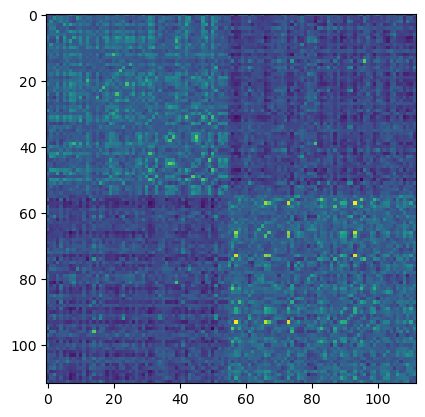

/tmp/ipykernel_9595/3652874760.py:69: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C)
/tmp/ipykernel_9595/3652874760.py:30: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  lam, v = sp.linalg.eigh(A, eigvals=(0,0))


[0 1 2 0 2 2 0 2 1 0 1 1 2 3 1 3 3 0 2 3 2 0 1 1 3 2 0 2 3 3 0 3 3 1 3 2 2
 0 2 3 3 1 2 2 0 0 2 3 0 0 1 2 2 0 0 1 0 2 2 3 2 0 3 3 0 3 0 0 0 0 0 0 2 0
 0 2 1 1 2 3 0 2 3 1 0 0 2 2 3 1 0 3 2 2 2 3 3 1 1 0 0 2 2 0 0 3 0 0 3 1 2
 1]
[36 19 32 25]
SCORE -0.2118182793566581


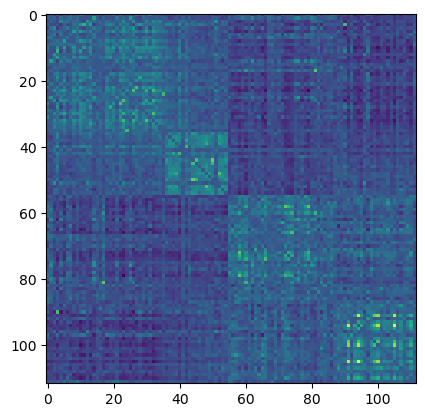

[1 2 4 0 5 5 0 5 3 0 3 2 4 7 2 6 6 0 5 6 5 0 2 2 6 5 0 4 7 7 1 7 7 2 6 5 4
 1 5 6 6 2 4 5 1 0 4 6 1 0 3 5 5 1 0 3 0 5 4 7 4 0 6 7 0 7 1 0 1 0 1 0 5 1
 0 5 3 2 4 6 1 4 6 2 0 0 4 5 6 2 1 6 5 4 4 7 7 3 2 1 0 4 5 0 1 7 0 0 6 3 4
 2]
[22 14 12  7 15 17 14 11]
SCORE -0.1917623125704782


/tmp/ipykernel_9595/3652874760.py:69: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C)
/tmp/ipykernel_9595/3652874760.py:30: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  lam, v = sp.linalg.eigh(A, eigvals=(0,0))


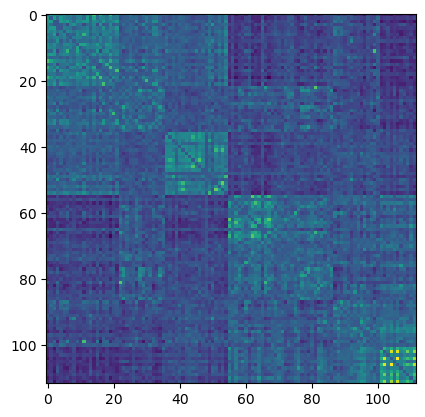

/tmp/ipykernel_9595/3652874760.py:69: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C)
/tmp/ipykernel_9595/3652874760.py:30: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  lam, v = sp.linalg.eigh(A, eigvals=(0,0))


[ 2  4  8  0 10 10  0 10  7  0  6  4  8 15  4 12 13  0 11 13 11  1  4  4
 12 10  1  9 14 15  2 15 14  5 12 11  8  3 10 13 13  5  8 10  2  1  8 13
  2  1  6 11 11  2  1  6  0 11  9 14  8  1 13 14  1 14  2  0  3  0  3  0
 10  3  1 11  7  4  9 12  3  8 13  4  1  0  9 11 12  5  2 13 10  9  9 15
 15  6  5  2  1  8 11  1  3 15  1  0 12  6  8  4]
[10 12  8  6  8  4  5  2  9  6  8  9  6  8  5  6]
SCORE -0.18047552366019043


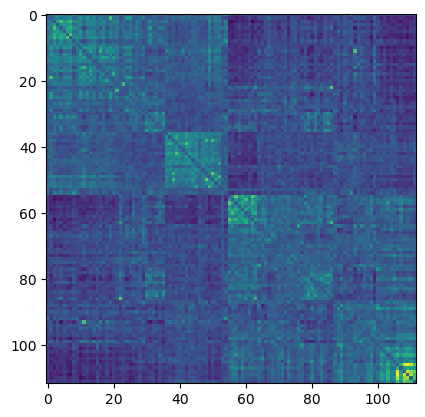

/tmp/ipykernel_9595/3652874760.py:69: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C)
/tmp/ipykernel_9595/3652874760.py:30: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  lam, v = sp.linalg.eigh(A, eigvals=(0,0))


[ 5  8 17  0 20 20  0 20 14  0 13  8 17 31  9 25 26  1 23 27 23  2  9  9
 25 20  3 19 29 31  5 30 29 11 25 22 16  7 20 26 26 10 16 20  4  3 17 26
  4  3 12 22 22  5  3 13  1 23 19 29 17  2 27 29  2 28  4  0  6  0  6  1
 21  7  2 23 15  9 19 24  7 16 27  9  3  0 18 22 25 11  5 26 21 18 19 31
 31 13 10  5  3 16 23  2  7 31  2  0 25 12 17  9]
[7 3 6 6 3 5 2 4 2 6 2 2 2 3 1 1 4 5 2 4 6 2 4 5 1 5 5 3 1 4 1 5]
SCORE -0.19660747252077931


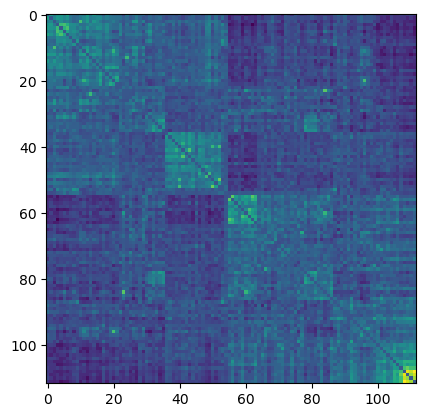

/tmp/ipykernel_9595/3652874760.py:69: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C)
/tmp/ipykernel_9595/3652874760.py:30: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  lam, v = sp.linalg.eigh(A, eigvals=(0,0))


[0 1 0 1 0 0 1 0 1 1 1 1 0 0 1 0 0 1 0 0 0 1 1 1 1 1 0 0 0 0 1 0 0 1 1 0 0
 0 0 0 0 1 0 0 1 1 0 1 0 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 0 1
 1 0 1 1 0 1 1 0 0 1 1 1 0 0 0 1 1 0 0 1 0 0 1 0 0 1 1 0 1 1 0 0 1 1 0 1 0
 1]
[57 55]
SCORE -1.056313664484517


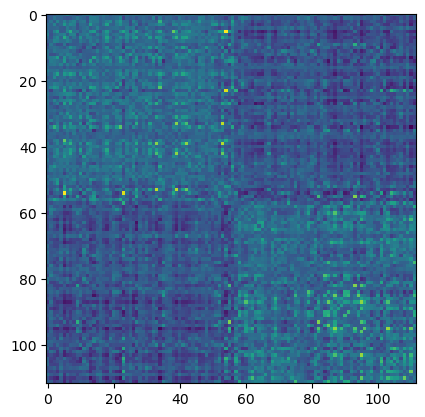

[1 3 1 2 1 1 2 0 3 2 3 3 0 0 3 1 1 2 1 1 1 2 3 3 3 3 0 1 0 0 3 1 0 3 3 1 1
 1 0 1 0 3 0 1 2 2 0 3 1 2 2 1 1 1 2 3 2 1 1 1 1 0 0 3 2 3 2 2 0 2 3 2 1 3
 2 0 2 3 1 3 2 1 0 3 2 2 1 1 0 3 2 1 1 3 1 0 3 0 0 2 2 1 2 2 1 0 2 3 0 2 0
 3]
[23 34 28 27]
SCORE -1.0236049186476783


/tmp/ipykernel_9595/3652874760.py:69: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C)
/tmp/ipykernel_9595/3652874760.py:30: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  lam, v = sp.linalg.eigh(A, eigvals=(0,0))


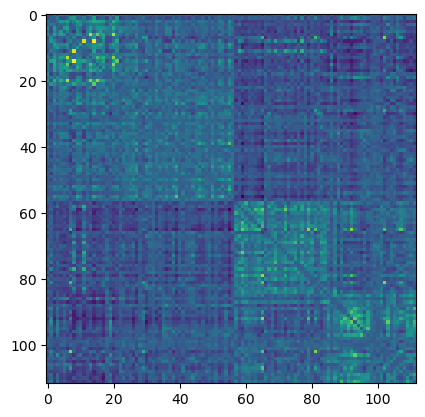

/tmp/ipykernel_9595/3652874760.py:69: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C)
/tmp/ipykernel_9595/3652874760.py:30: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  lam, v = sp.linalg.eigh(A, eigvals=(0,0))


[2 6 3 4 2 2 4 1 6 4 6 6 0 1 6 2 2 5 3 3 3 4 6 6 7 6 1 2 0 1 7 2 0 6 7 3 3
 3 1 2 1 6 1 3 4 5 1 6 2 5 4 3 3 2 4 6 4 3 2 3 3 1 1 6 4 7 4 4 0 4 7 5 2 6
 5 1 5 6 2 6 5 2 1 6 4 4 3 3 1 6 4 2 2 6 2 0 7 1 1 4 4 3 5 4 3 1 4 6 1 4 1
 6]
[ 5 18 17 17 20  8 21  6]
SCORE -1.009490965088439


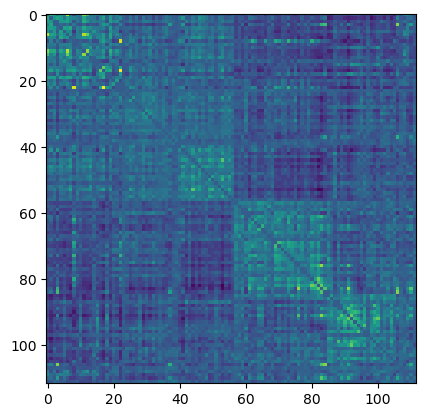

/tmp/ipykernel_9595/3652874760.py:69: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C)
/tmp/ipykernel_9595/3652874760.py:30: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  lam, v = sp.linalg.eigh(A, eigvals=(0,0))


[ 0 13  7  9  4  4  8  2 13  9 13 13  0  3 13  4  2 11  7  7  7  8 12 13
 14 12  2  4  1  3 14  2  0 12 15  6  7  6  2  4  2 13  3  7  8  9  3 12
  4 10  8  6  6  4  8 13  9  7  4  7  7  2  3 12  8 14  8  8  0  9 14  9
  0 12 10  3 10 13  4 13 10  0  3 12  8  9  7  6  3 12  8  5  4 12  4  0
 14  2  2  8  8  7 10  8  6  3  9 12  2  8  3 13]
[ 7  1 10 10 11  1  6 11 14  8  5  1 10 11  5  1]
SCORE -1.0257877709722365


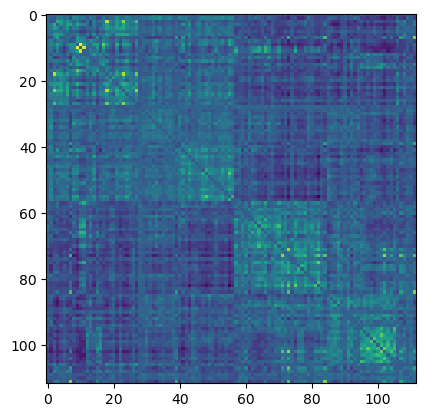

[0 1 0 1 0 0 1 0 1 1 1 1 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 1 1 0 0
 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 0 1
 1 0 1 1 0 1 1 0 1 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 1 1 0 1 1 0 0 1 1 0 1 0
 1]
[61 51]
SCORE -1.1058889658904691


/tmp/ipykernel_9595/3652874760.py:69: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C)
/tmp/ipykernel_9595/3652874760.py:30: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  lam, v = sp.linalg.eigh(A, eigvals=(0,0))


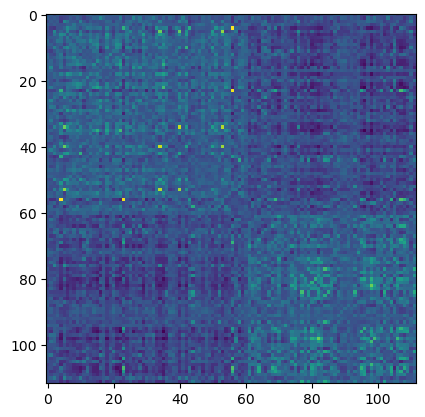

/tmp/ipykernel_9595/3652874760.py:69: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C)


[0 3 0 2 0 0 2 1 3 3 3 3 1 1 3 0 1 2 0 0 0 2 3 0 3 0 1 0 1 1 3 1 1 2 3 0 0
 0 1 0 1 3 1 0 2 2 1 1 1 2 2 0 0 0 2 3 2 0 0 0 0 1 1 3 2 3 2 2 0 2 3 3 0 3
 2 0 2 3 0 3 3 1 3 3 2 2 0 0 1 3 2 0 1 0 1 1 3 1 1 2 2 0 3 2 0 1 2 3 1 2 1
 3]
[33 27 25 27]
SCORE -1.0774395159175532


/tmp/ipykernel_9595/3652874760.py:30: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  lam, v = sp.linalg.eigh(A, eigvals=(0,0))


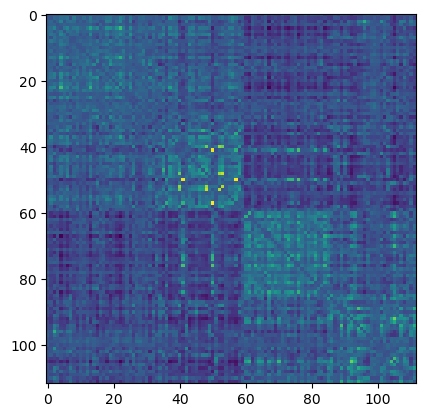

/tmp/ipykernel_9595/3652874760.py:69: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C)
/tmp/ipykernel_9595/3652874760.py:30: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  lam, v = sp.linalg.eigh(A, eigvals=(0,0))


[1 6 0 4 1 1 5 3 7 7 6 6 2 2 1 1 3 5 1 1 0 4 6 1 6 1 3 1 2 2 6 3 2 5 6 1 1
 0 3 1 3 6 2 0 4 4 2 3 3 4 4 0 0 1 4 6 4 0 1 1 0 3 2 6 4 6 5 4 0 4 7 7 1 7
 4 0 4 6 1 7 6 3 7 6 5 5 0 0 2 7 4 1 2 1 3 2 7 3 3 5 4 1 6 4 0 2 5 7 3 4 2
 6]
[13 21 13 14 17  8 16 10]
SCORE -1.0559132135873939


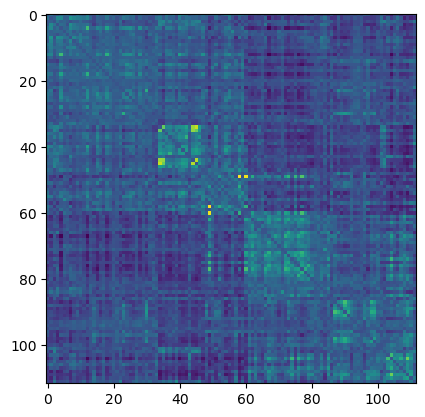

/tmp/ipykernel_9595/3652874760.py:69: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C)
/tmp/ipykernel_9595/3652874760.py:30: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  lam, v = sp.linalg.eigh(A, eigvals=(0,0))


[ 2 13  1  8  3  3 11  6 15 15 13 13  4  4  2  2  7 10  3  3  1  8 13  2
 12  2  6  2  5  4 12  7  4 11 12  3  3  0  7  2  6 13  4  1  8  9  4  7
  7  8  9  0  0  2  9 13  8  1  2  2  0  6  4 12  8 13 11  8  1  8 14 15
  2 15  9  1  9 13  2 15 12  7 15 13 11 11  1  0  4 15  8  3  4  3  7  4
 15  6  7 11  9  3 12  8  0  4 11 15  6  9  4 13]
[ 6  7 12  9 12  1  6  8 10  7  1  7  6 10  1  9]
SCORE -1.0678333857960507


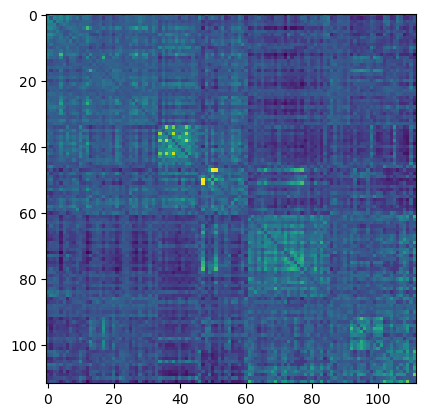

[1 1 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 0 1 0 0 1 1 1 1 1 0 1 1 0 1 0 0 0 1 1 0
 1 0 1 0 0 0 0 1 0 1 1 0 1 0 1 1 1 0 1 0 0 1 1 1 0 1 1 0 0 1 1 0 1 0 0 1 1
 0 0 0 1 1 0 1 0 1 1 0 1 1 0 0 1 1 1 1 0 1 0 1 0 0 1 0 1 1 1 1 0 0 1 0 0 0
 1]
[52 60]
SCORE -0.3717716893253675


/tmp/ipykernel_9595/3652874760.py:69: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C)
/tmp/ipykernel_9595/3652874760.py:30: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  lam, v = sp.linalg.eigh(A, eigvals=(0,0))


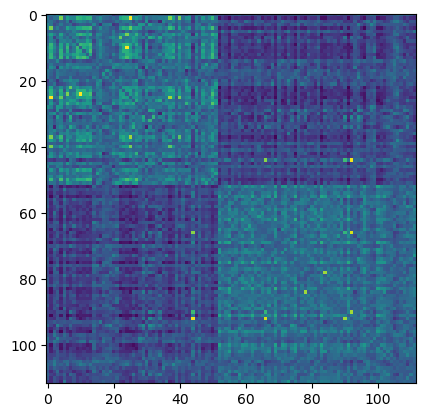

[2 3 1 1 2 2 1 1 1 2 0 3 0 1 2 2 3 1 3 1 0 2 3 3 3 3 0 2 3 0 2 1 0 0 3 3 1
 2 0 2 0 0 0 0 2 0 3 3 1 3 0 2 2 2 0 3 1 1 2 3 3 0 3 3 0 1 2 2 0 2 1 1 2 3
 0 0 1 3 3 0 2 1 3 3 0 2 2 0 1 3 2 3 3 0 3 1 3 0 0 2 0 3 3 2 2 1 1 3 0 0 0
 3]
[30 22 27 33]
SCORE -0.35096064441092645


/tmp/ipykernel_9595/3652874760.py:69: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C)
/tmp/ipykernel_9595/3652874760.py:30: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  lam, v = sp.linalg.eigh(A, eigvals=(0,0))


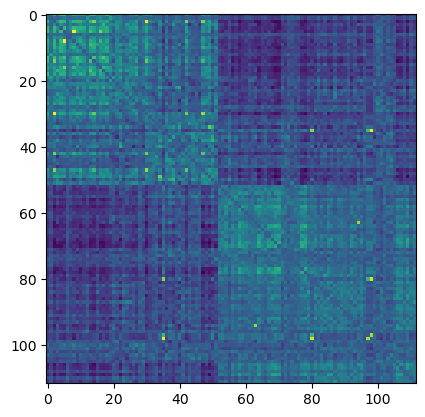

/tmp/ipykernel_9595/3652874760.py:69: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C)
/tmp/ipykernel_9595/3652874760.py:30: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  lam, v = sp.linalg.eigh(A, eigvals=(0,0))


[4 7 2 2 4 4 2 3 3 5 1 7 1 2 4 4 7 3 7 3 1 5 7 7 7 7 1 4 6 1 4 2 1 0 6 6 2
 5 1 4 1 1 1 1 5 0 6 7 2 7 0 5 5 4 0 7 2 2 4 7 6 1 7 7 0 3 5 5 0 5 2 2 5 7
 0 1 2 7 7 0 4 2 7 7 0 5 4 0 2 7 4 6 7 0 7 2 7 0 1 4 0 7 7 4 5 2 2 7 0 0 1
 7]
[15 15 17  5 15 12  6 27]
SCORE -0.33440417405443645


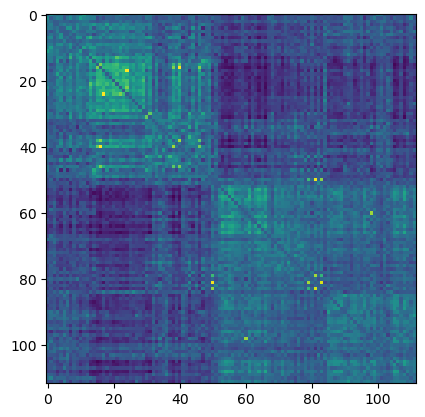

/tmp/ipykernel_9595/3652874760.py:69: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C)
/tmp/ipykernel_9595/3652874760.py:30: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  lam, v = sp.linalg.eigh(A, eigvals=(0,0))


[ 9 15  5  4  9  8  4  6  6 11  2 15  3  5  9  8 15  7 14  6  2 10 15 14
 15 14  2  9 12  3  8  5  3  0 13 12  5 10  2  9  2  2  3  2 10  1 12 14
  5 15  0 10 10  9  1 15  4  5  8 14 12  2 14 14  1  6 11 11  0 11  4  4
 11 14  0  3  4 15 14  0  8  5 14 15  1 11  8  0  5 15  9 13 14  1 14  3
 15  0  2  8  1 15 14  9 10  5  4 14  1  0  3 15]
[ 8  7  9  7  7  9  4  1  7  8  6  6  4  2 14 13]
SCORE -0.31786383679928126


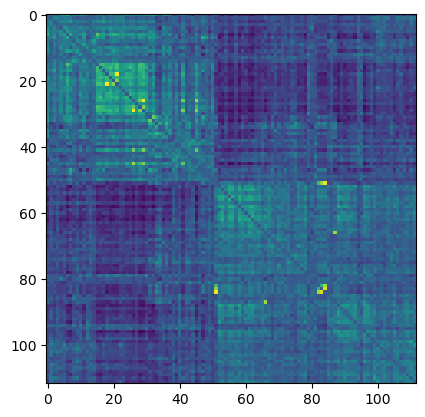

In [4]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import scipy as sp

def get_cut(X):

    y = X
    X = np.hstack((X, np.ones((X.shape[0], 1))))
    
    y2 = np.sum(y**2, axis=1, keepdims=True)/2

    y = np.hstack((y, y2, 0*y+1, y2 + 1))
    
    
    yX = np.matmul(y.T, X)

    
    minkowski = -np.ones((y.shape[1],1))
    minkowski[-1,0] = +1.0
 
    A = np.matmul(yX.T, minkowski*yX)
    
    Ao = np.expand_dims(A[:-1,-1],1)
    Aoo = A[-1,-1]
    A = A[:-1,:-1] - np.matmul(Ao, Ao.T)/Aoo
    
    
    lam, v = sp.linalg.eigh(A, eigvals=(0,0))
    v = np.vstack((v, -np.dot(Ao[:,0],v)/Aoo))
    
    
    c = np.matmul(X, v) > 0.0
    
    return c[:,0]


def otree_clusters(X, max_depth):
    
    sets = np.zeros((X.shape[0])).astype(int)

    for k in range(max_depth):
        new_sets = 0*sets
        
        for kk in range(np.max(sets)+1):
            b = sets==kk
            
            Xs = X[b, :]
            
            
            c = get_cut(Xs)
            
            
            new_sets[b] = 2*sets[b] + c
        sets = new_sets
        
    return sets



def get_clusters(x, depth=3):  
    x[~np.isfinite(x)] = np.mean(x[np.isfinite(x)]) # x shape of (time_id=3830,stock_id= 112)

    x = x - np.nanmean(x, 0)
    x = x / (np.nanstd(x, 0)+1e-20)
    
    C = np.corrcoef(x.T)
    C = np.arctanh(C)
    a = np.arange(C.shape[0])
    C[a,a] = 0
        
    m = np.mean(C, 1, keepdims=True)
    C = C - (m + m.T)
    C[a,a] = np.mean(C)

    pca = PCA(x.shape[1])
    
    pca.fit(x)
    c = pca.components_ * pca.singular_values_[:,np.newaxis]**.5
    
    c = c.T
    
    c[:,0] = c[:,0]

    p = otree_clusters(c, depth)

    # print('p',p)
    # print('clusters',np.max(p)+1)
    # print('shape',p.shape)
    
    means = []    
    for k in range(np.max(p)+1):
        mn = np.mean(c[p==k, :], 0)
        means.append(mn)
    means= np.vstack(means)
    
    gm = GaussianMixture(means.shape[0], means_init=means, weights_init=np.ones(means.shape[0])/means.shape[0], covariance_type='full', 
                         precisions_init=np.repeat( np.eye(means.shape[1])[np.newaxis,:,:]/means.shape[1], repeats=means.shape[0], axis=0) )
                             
    p = gm.fit_predict(c)
    
    print(p)    
    _, cnts = np.unique( p, return_counts=True)
    print(cnts)

    score=0
    nc= np.max(p)+1
    for k in range(nc):
        Q =  C[p==k,:][:,p==k]
        score += np.mean(Q)/nc
    print('SCORE', score)
    
    
    k = np.argsort(p)
    
    plt.imshow( (C[k,:][:,k]) )
    plt.show()

    return p

def high_corr_set(x, q):  
    x[~np.isfinite(x)] = np.mean(x[np.isfinite(x)])

    x = x - np.nanmean(x, 0)
    x = x / np.nanstd(x, 0)
    
    C = np.corrcoef(x.T)
    c = np.median(C, 1)
    
    b = c > np.quantile(c,q)
    
    idxs =  np.arange(c.shape[0])[b]

    return idxs


rvol   = train_binned['root_volume']
vol    = train_binned['volume']
vol1   = train_binned['vol1']
lr1   = train_binned['lr1']
lsprd  = train_binned['log_spread']
r4liq3 = train_binned['liquidity3_4th_root']
liq2   = train_binned['liquidity2']

lr1 = np.mean(lr1,2)
vol1 = np.mean(vol1**2, 2)**.5
tvpl3 = np.log(np.mean( rvol, 2)**(1/2)/np.mean( (r4liq3[:,:, 0:]), 2)**(4/3))
rvol = np.log(np.mean(rvol**.5,2))
lsprd = (np.mean(lsprd,2))
vol1 = np.log(vol1)
vol = (np.mean(vol,2) )


lr1_clusters1 = get_clusters(lr1, depth=1)
lr1_clusters2 = get_clusters(lr1, depth=2)
lr1_clusters3 = get_clusters(lr1, depth=3)
lr1_clusters4 = get_clusters(lr1, depth=4)
lr1_clusters5 = get_clusters(lr1, depth=5)

lr1_hc = high_corr_set(lr1, .9)

tvpl3_clusters1 = get_clusters(tvpl3, depth=1)
tvpl3_clusters2 = get_clusters(tvpl3, depth=2)
tvpl3_clusters3 = get_clusters(tvpl3, depth=3)
tvpl3_clusters4 = get_clusters(tvpl3, depth=4)

vol1_clusters1 = get_clusters(vol1, depth=1)
vol1_clusters2 = get_clusters(vol1, depth=2)
vol1_clusters3 = get_clusters(vol1, depth=3)
vol1_clusters4 = get_clusters(vol1, depth=4)

vol1_hc = high_corr_set(vol1, .95)

vol_clusters1 = get_clusters(rvol, depth=1)
vol_clusters2 = get_clusters(rvol, depth=2)
vol_clusters3 = get_clusters(rvol, depth=3)
vol_clusters4 = get_clusters(rvol, depth=4)


del rvol, vol, vol1, lr1, lsprd, r4liq3, liq2



## Features

In [7]:

def nancorr(a, b):
    v = np.isfinite(a)*np.isfinite(b) > 0
    return np.corrcoef(a[v], b[v])[0,1]


def plot_by_sid(train, x, y):
    for u in np.unique(train['stock_id']):
        b = train['stock_id']==u
        plt.plot(x[b], y[b], '.', markersize=1)
    plt.show()
    



def cluster_agg(x, clusters, agg_fun):
    r = 0*x
    
    for k in range(np.max(clusters)+1):
        z = agg_fun(x[:,clusters==k,:], 1, keepdims=True)
        r[:,clusters==k,:] = np.repeat(z, repeats=int(np.sum(clusters==k)), axis=1)
    return r
    

def keys_to_array(d, features):
    
    sh = np.max( [d[f].shape[1] for f in features] )
    sq = np.max( [d[f].shape[0] for f in features] )
    
    for f in features:
        if d[f].shape[1]==1:
            d[f] = np.repeat(d[f], repeats=sh, axis=1)
        if d[f].shape[0]==1:
            d[f] = np.repeat(d[f], repeats=sq, axis=0)
        
    
    stack = [d[feature] for feature in features]
    
    X = np.dstack(stack)
    
    return X


def merge_features_to_df(fdict, df, features):
    sids = df['stock_id'].unique()

    T = fdict['time_ids'][:,:,0]
    S = fdict['stock_ids'][:,:,0]

    T = np.reshape(T, [T.shape[0]*T.shape[1]])
    S = np.reshape(S, [S.shape[0]*S.shape[1]])
    
    sh = np.max( [fdict[f].shape[1] for f in features] )
    sq = np.max( [fdict[f].shape[0] for f in features] )
    
    for f in features:
        if fdict[f].shape[1]==1:
            fdict[f] = np.repeat(fdict[f], repeats=sh, axis=1)
        if fdict[f].shape[0]==1:
            fdict[f] = np.repeat(fdict[f], repeats=sq, axis=0)
        
    
    reshaped_features = [np.reshape( fdict[feature], [fdict[feature].shape[0]*fdict[feature].shape[1]] )
                         for feature in features]


    
    dfz = pd.DataFrame(data=np.vstack([S,T] + reshaped_features  ).T, columns=['stock_id', 'time_id']+features)
    dfz['time_id' ] = dfz['time_id' ].astype(int)
    dfz['stock_id'] = dfz['stock_id'].astype(int)

    dfz = df.merge(dfz, on=['stock_id', 'time_id'], how='left')
    return dfz



def get_simple_features(binned_features, final_features, name, ffrom=0):
    v = binned_features[name]

    suffix = f'_from_{ffrom}'

    s  = np.mean(np.mean(v**2, (2), keepdims=True)**.5, 0, keepdims=True)

    final_features[name + suffix] =            np.log(             np.mean(v[:,:,ffrom:]**2, 2, keepdims=True)**0.5/final_features['vol1'])
    final_features[name+'stock_mean'+suffix] = np.log(s*np.median( np.mean( v[:,:,ffrom:]/s, 2, keepdims=True), 1, keepdims=True)/final_features['vol1'])

    

def get_cohesion_features(binned_features, final_features, ffrom=0):
    lr1 = binned_features['lr1']

    if ffrom > 0:
        suffix = f'_from_{ffrom}'
    else:
        suffix = ''
    
    s = np.mean( np.var(lr1, 0,keepdims=True), 2, keepdims=True)**0.5
    qs = lr1[:,:,ffrom:]/s

    final_features['tbin_var'               + suffix] = s*np.mean(  np.var( qs, 1, keepdims=True)         , 2, keepdims=True)**0.5/final_features['vol1']
    final_features['market_var'             + suffix] = s*np.mean( (np.mean(qs, 1, keepdims=True)     )**2, 2, keepdims=True)**0.5/final_features['vol1']
    final_features['deviations_from_market' + suffix] = s*np.mean( (np.mean(qs, 1, keepdims=True) - qs)**2, 2, keepdims=True)**0.5/final_features['vol1']
    
    



def get_misc_features(binned_features, final_features):
    vol    = binned_features['volume']
    vol1    = binned_features['vol1']

    rvol   = binned_features['root_volume']

    volcr  = binned_features['cube_root_volume']
    liq2   = binned_features['liquidity2']
    liq3   = binned_features['liquidity3']
    r4liq3 = binned_features['liquidity3_4th_root']
    lsprd  = binned_features['log_spread2']
    bsz  = binned_features['book_size']

    
    s  = np.nanmean( vol, (0,2), keepdims=True)
    sr = np.nanmean(rvol, (0,2), keepdims=True)
    l2 = np.nanmean(liq2, (0,2), keepdims=True)
    l3 = np.nanmean(liq3, (0,2), keepdims=True)

    v1 = np.nanmean(vol1**2, 2, keepdims=True)**.5
    
    final_features['soft_stock_mean_tvpl2'    ] = np.log( (s/l2*np.nanmean( (vol[:,:, 0:]/liq2[:,:, 0:]*l2/s)**(1/8), (1,2), keepdims=True)**8)**.5/v1)
    final_features['soft_stock_mean_tvpl2_f10'] = np.log( (s/l2*np.nanmean( (vol[:,:,10:]/liq2[:,:,10:]*l2/s)**(1/8), (1,2), keepdims=True)**8)**.5/v1)
    final_features['soft_stock_mean_tvpl2_f20'] = np.log( (s/l2*np.nanmean( (vol[:,:,20:]/liq2[:,:,20:]*l2/s)**(1/8), (1,2), keepdims=True)**8)**.5/v1)
    
    final_features['soft_stock_mean_tvpl3'    ] = np.log( (sr/l3*np.nanmean( (rvol[:,:, 0:]/liq3[:,:, 0:]*l3/sr)**(1/8), (1,2), keepdims=True)**8)**(1/3)/v1)
    final_features['soft_stock_mean_tvpl3_f10'] = np.log( (sr/l3*np.nanmean( (rvol[:,:,10:]/liq3[:,:,10:]*l3/sr)**(1/8), (1,2), keepdims=True)**8)**(1/3)/v1)
    final_features['soft_stock_mean_tvpl3_f20'] = np.log( (sr/l3*np.nanmean( (rvol[:,:,20:]/liq3[:,:,20:]*l3/sr)**(1/8), (1,2), keepdims=True)**8)**(1/3)/v1)
    
    final_features['soft_stock_mean_tvpl2_liqf'       ] = np.log( (s/l2*np.nanmean( (vol[:,:, 0:]/liq2[:,:,-1:]*l2/s)**(1/8), (1,2), keepdims=True)**8)**.5/v1)
    final_features['soft_stock_mean_tvpl2_liqf_volf10'] = np.log( (s/l2*np.nanmean( (vol[:,:,10:]/liq2[:,:,-1:]*l2/s)**(1/8), (1,2), keepdims=True)**8)**.5/v1)
    final_features['soft_stock_mean_tvpl2_liqf_volf20'] = np.log( (s/l2*np.nanmean( (vol[:,:,20:]/liq2[:,:,-1:]*l2/s)**(1/8), (1,2), keepdims=True)**8)**.5/v1)
    
    final_features['soft_stock_mean_tvpl3_liqf'       ] = np.log( (sr/l3*np.nanmean( (rvol[:,:, 0:]/liq3[:,:,-1:]*l3/sr)**(1/8), (1,2), keepdims=True)**8)**(1/3)/v1)
    final_features['soft_stock_mean_tvpl3_liqf_volf10'] = np.log( (sr/l3*np.nanmean( (rvol[:,:,10:]/liq3[:,:,-1:]*l3/sr)**(1/8), (1,2), keepdims=True)**8)**(1/3)/v1)
    final_features['soft_stock_mean_tvpl3_liqf_volf20'] = np.log( (sr/l3*np.nanmean( (rvol[:,:,20:]/liq3[:,:,-1:]*l3/sr)**(1/8), (1,2), keepdims=True)**8)**(1/3)/v1)
    
    

    tvpl3     = np.log( np.mean( rvol, 2, keepdims=True)**(1/2)/np.mean( (r4liq3[:,:, 0:]), (2), keepdims=True)**(4/3)/v1)
    tvpl3lf20 = np.log( np.mean( rvol, 2, keepdims=True)**(1/2)/np.mean( (r4liq3[:,:, 20:]), (2), keepdims=True)**(4/3)/v1)
    
    final_features['tvpl3_rmed2v1']     = np.log( np.median(tvpl3/v1,1, keepdims=True)    )
    final_features['tvpl3_rmed2v1lf20'] = np.log( np.median(tvpl3lf20/v1,1, keepdims=True))
    
    
    
    final_features['v1proj_25_15'] = np.log( np.nanmedian( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                         / np.mean(vol1[:,:,:15]**2,2,keepdims=True),1,keepdims=True)**.5 )
    
    
    final_features['v1proj_25_15_lr1_hc'] = np.log( np.nanmedian( np.mean(vol1[:,lr1_hc,25:]**2,2,keepdims=True)
                                                                / np.mean(vol1[:,lr1_hc,:15]**2,2,keepdims=True),1,keepdims=True)**.5 )
    
    final_features['v1proj_25_15_vol1_hc'] = np.log( np.nanmedian( np.mean(vol1[:,vol1_hc,25:]**2,2,keepdims=True)
                                                                 / np.mean(vol1[:,vol1_hc,:15]**2,2,keepdims=True),1,keepdims=True)**.5 ) 
    final_features['v1proj_25_lr1_hc']     = np.log( np.nanmedian( np.mean(vol1[:,lr1_hc,25:]**2,2,keepdims=True)
                                                             / np.mean(vol1[:,lr1_hc,:]**2,2,keepdims=True),1,keepdims=True)**.5 )
    final_features['v1proj_25_vol1_hc']    = np.log( np.nanmedian( np.mean(vol1[:,vol1_hc,25:]**2,2,keepdims=True)
                                                              / np.mean(vol1[:,vol1_hc,:]**2,2,keepdims=True),1,keepdims=True)**.5 )
    
    
    final_features['lsvol'] = np.log( np.nanmean(binned_features['lsvol'], 2, keepdims=True))    

    final_features['liqvol1'] = np.log( np.nanmean(binned_features['liqvol1'], 2, keepdims=True))    
    final_features['liqvol1_smean'] = np.log( np.nanmean(binned_features['liqvol1'], (1,2), keepdims=True))    

    final_features['liqvol1_smean_c3'] = np.log( cluster_agg(np.nanmean(binned_features['liqvol1'], 2, keepdims=True), lr1_clusters3,np.nanmedian))    

    
    
    final_features['liqvol2'] = np.log( np.nanmean(binned_features['liqvol2'], 2, keepdims=True))    
    final_features['liqvol3'] = np.log( np.nanmean(binned_features['liqvol3'], 2, keepdims=True))    

    
    final_features['liqvol1_15_15'] = np.log( np.nanmean(binned_features['liqvol1'][:,:,15:  ], 2, keepdims=True)
                                            /np.nanmean(binned_features['liqvol1'][:,:,  :15], 2, keepdims=True))    

    final_features['trade_count']      = np.log( np.nanmean(binned_features['trade_count']    , 2, keepdims=True))    
    final_features['root_trade_count'] = np.log( np.nanmean(binned_features['trade_count']**.5, 2, keepdims=True))    
    final_features['root_book_delta_count'] = np.log( np.nanmean(binned_features['book_delta_count']**.5, 2, keepdims=True))    

    final_features['root_trade_count_smean'] = np.log( np.nanmean(binned_features['trade_count']**.5, (1,2), keepdims=True))    

    final_features['root_trade_count_smean_c1'] = np.log( cluster_agg(np.nanmean(binned_features['trade_count']**0.5, 2, keepdims=True),
                                                                     lr1_clusters1,np.nanmean))
    final_features['root_trade_count_smean_c2'] = np.log( cluster_agg(np.nanmean(binned_features['trade_count']**0.5, 2, keepdims=True),
                                                                     lr1_clusters2,np.nanmean))
    final_features['root_trade_count_smean_c3'] = np.log( cluster_agg(np.nanmean(binned_features['trade_count']**0.5, 2, keepdims=True),
                                                                     lr1_clusters3,np.nanmean))    
    final_features['root_trade_count_var'] = np.log( np.nanvar(binned_features['trade_count']**.5, 2, keepdims=True))    

    
    final_features['root_book_delta_count_smean'] = np.log( np.nanmean(binned_features['book_delta_count']**.5, (1,2), keepdims=True))    

    final_features['root_book_delta_count_smean_c1'] = np.log( cluster_agg(np.nanmean(binned_features['book_delta_count']**0.5, 2, keepdims=True),
                                                                     lr1_clusters1,np.nanmean))
    final_features['root_book_delta_smean_c2'] = np.log( cluster_agg(np.nanmean(binned_features['book_delta_count']**0.5, 2, keepdims=True),
                                                                     lr1_clusters2,np.nanmean))
    final_features['root_book_delta_count_smean_c3'] = np.log( cluster_agg(np.nanmean(binned_features['book_delta_count']**0.5, 2, keepdims=True),
                                                                     lr1_clusters3,np.nanmean))    
    final_features['root_book_delta_count_var'] = np.log( np.nanvar(binned_features['book_delta_count']**.5, 2, keepdims=True))    

    
    
    final_features['trade_count_15_15']      = np.log( np.nanmean(binned_features['trade_count'][:,:,15:  ], 2, keepdims=True)/
                                                      np.nanmean(binned_features['trade_count'][:,:,  :15], 2, keepdims=True))    
    final_features['root_trade_count_15_15'] =  np.log( np.nanmean(binned_features['trade_count'][:,:,15:  ]**.5, 2, keepdims=True)/
                                                       np.nanmean(binned_features['trade_count'][:,:,  :15]**.5, 2, keepdims=True)) 
    
    
    final_features['v1proj_29_15'] = np.log( np.nanmedian( np.mean(vol1[:,:,29:  ]**2,2,keepdims=True)
                                                        / np.mean(vol1[:,:,  :15]**2,2,keepdims=True),1,keepdims=True)**.5)
    final_features['v1proj_20']    = np.log( np.nanmedian( np.mean(vol1[:,:,20:  ]**2,2,keepdims=True)
                                                        / np.mean(vol1[:,:,  :  ]**2,2,keepdims=True),1,keepdims=True)**.5 )   
    final_features['v1proj_25']    = np.log( np.nanmedian( np.mean(vol1[:,:,25:  ]**2,2,keepdims=True) 
                                                        / np.mean(vol1[:,:,  :  ]**2,2,keepdims=True),1,keepdims=True)**.5 )
    final_features['v1proj_29']    = np.log( np.nanmedian( np.mean(vol1[:,:,28:  ]**2,2,keepdims=True)
                                                        / np.mean(vol1[:,:,  :  ]**2,2,keepdims=True),1,keepdims=True)**.5 )
    
    final_features['v1proj_29_q1'] = np.log( np.quantile( np.mean(vol1[:,:,28:]**2,2,keepdims=True)
                                                        / np.mean(vol1[:,:,:  ]**2,2,keepdims=True), 0.25, 1,keepdims=True)**.5 )
    final_features['v1proj_29_q3'] = np.log( np.quantile( np.mean(vol1[:,:,28:]**2,2,keepdims=True)
                                                        / np.mean(vol1[:,:,:  ]**2,2,keepdims=True), 0.75, 1,keepdims=True)**.5 )
    final_features['v1proj_25_q1'] = np.log( np.quantile( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                        / np.mean(vol1[:,:,:  ]**2,2,keepdims=True), 0.25, 1,keepdims=True)**.5 )
    final_features['v1proj_25_q3'] = np.log( np.quantile( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                        / np.mean(vol1[:,:,:  ]**2,2,keepdims=True), 0.75, 1,keepdims=True)**.5 ) 
    
    final_features['v1proj_29_15_q1'] = np.log( np.quantile( np.mean(vol1[:,:,28:  ]**2,2,keepdims=True)
                                                           / np.mean(vol1[:,:,  :15]**2,2,keepdims=True), 0.25, 1,keepdims=True)**.5 )
    final_features['v1proj_29_15_q3'] = np.log( np.quantile( np.mean(vol1[:,:,28:  ]**2,2,keepdims=True)
                                                           / np.mean(vol1[:,:,  :15]**2,2,keepdims=True), 0.75, 1,keepdims=True)**.5 )
    final_features['v1proj_25_15_q1'] = np.log( np.quantile( np.mean(vol1[:,:,25:  ]**2,2,keepdims=True)
                                                           / np.mean(vol1[:,:,  :15]**2,2,keepdims=True), 0.25, 1,keepdims=True)**.5 )
    final_features['v1proj_25_15_q3'] = np.log( np.quantile( np.mean(vol1[:,:,25:  ]**2,2,keepdims=True)
                                                           / np.mean(vol1[:,:,  :15]**2,2,keepdims=True), 0.75, 1,keepdims=True)**.5 )
    
    
      
    
    
    
    
    final_features['v1proj_25_15_std'] = np.log( np.nanstd( np.log( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                               / np.mean(vol1[:,:,:15]**2,2,keepdims=True)),1,keepdims=True)**.5 )
    final_features['v1proj_29_15_std'] = np.log( np.nanstd( np.log( np.mean(vol1[:,:,29:]**2,2,keepdims=True)
                                                               / np.mean(vol1[:,:,:15]**2,2,keepdims=True)),1,keepdims=True)**.5 )
    
    final_features['v1proj_20_std'] = np.log( np.nanstd( np.log(np.mean(vol1[:,:,20:]**2,2,keepdims=True)
                                                            /np.mean(vol1[:,:,:  ]**2,2,keepdims=True))
                                                    ,1,keepdims=True) )
    final_features['v1proj_25_std'] = np.log( np.nanstd( np.log(np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                            /np.mean(vol1[:,:,:  ]**2,2,keepdims=True))
                                                    ,1,keepdims=True) )
    final_features['v1proj_29_std'] = np.log( np.nanstd( np.log(np.mean(vol1[:,:,28:]**2,2,keepdims=True)
                                                            /np.mean(vol1[:,:,:  ]**2,2,keepdims=True))
                                                    ,1,keepdims=True) )
    
    
    final_features['v1proj_29_q3q1'] = np.log(np.quantile( np.log(np.mean(vol1[:,:,28:]**2,2,keepdims=True)
                                                            /np.mean(vol1[:,:,:  ]**2,2,keepdims=True))
                                                    ,0.75, axis=1,keepdims=True)
                                                -
                                                np.quantile( np.log(np.mean(vol1[:,:,28:]**2,2,keepdims=True)
                                                            /np.mean(vol1[:,:,:  ]**2,2,keepdims=True))
                                                    ,0.25, axis=1,keepdims=True))
    
    if vol1.shape[1]>100:
        final_features['v1proj_25_c1'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        lr1_clusters1, np.median)**0.5 )  
        final_features['v1proj_25_c2'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        lr1_clusters2, np.median)**0.5 )
        final_features['v1proj_25_c3'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        lr1_clusters3, np.median)**0.5 )
        final_features['v1proj_25_c4'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        lr1_clusters4, np.median)**0.5 )
        final_features['v1proj_25_c5'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        lr1_clusters5, np.median)**0.5 )
        
  

        final_features['soft_stock_mean_tvpl2_c1'] = np.log( s/l2*cluster_agg(
            np.nanmean( (vol[:,:, 0:]/liq2[:,:, 0:]*l2/s)**(1/8), 2, keepdims=True),
                lr1_clusters1, np.mean)**8**.5/v1)
        final_features['soft_stock_mean_tvpl2_c2'] = np.log( s/l2*cluster_agg(
            np.nanmean( (vol[:,:, 0:]/liq2[:,:, 0:]*l2/s)**(1/8), 2, keepdims=True),
                lr1_clusters2, np.mean)**8**.5/v1)
        final_features['soft_stock_mean_tvpl2_c3'] = np.log( s/l2*cluster_agg(
            np.nanmean( (vol[:,:, 0:]/liq2[:,:, 0:]*l2/s)**(1/8), 2, keepdims=True),
                lr1_clusters3, np.mean)**8**.5/v1)
        
        final_features['soft_stock_mean_tvpl2_10_c1'] = np.log( s/l2*cluster_agg(
            np.nanmean( (vol[:,:, 10:]/liq2[:,:,10:]*l2/s)**(1/8), 2, keepdims=True),
                lr1_clusters1, np.mean)**8**.5/v1)
        final_features['soft_stock_mean_tvpl2_10_c2'] = np.log( s/l2*cluster_agg(
            np.nanmean( (vol[:,:, 10:]/liq2[:,:,10:]*l2/s)**(1/8), 2, keepdims=True),
                lr1_clusters2, np.mean)**8**.5/v1)
        final_features['soft_stock_mean_tvpl2_10_c3'] = np.log( s/l2*cluster_agg(
            np.nanmean( (vol[:,:, 10:]/liq2[:,:,10:]*l2/s)**(1/8), 2, keepdims=True),
                lr1_clusters3, np.mean)**8**.5/v1)
        
        final_features['soft_stock_mean_tvpl2_20_c1'] = np.log( s/l2*cluster_agg(
            np.nanmean( (vol[:,:, 20:]/liq2[:,:,20:]*l2/s)**(1/8), 2, keepdims=True),
                lr1_clusters1, np.mean)**8**.5/v1)
        final_features['soft_stock_mean_tvpl2_20_c2'] = np.log( s/l2*cluster_agg(
            np.nanmean( (vol[:,:, 20:]/liq2[:,:,20:]*l2/s)**(1/8), 2, keepdims=True),
                lr1_clusters2, np.mean)**8**.5/v1)
        final_features['soft_stock_mean_tvpl2_20_c3'] = np.log( s/l2*cluster_agg(
            np.nanmean( (vol[:,:, 20:]/liq2[:,:,20:]*l2/s)**(1/8), 2, keepdims=True),
                lr1_clusters3, np.mean)**8**.5/v1)

        
        final_features['v1proj_25_c1_std'] = np.log( cluster_agg( np.log(np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True)),
                                                        lr1_clusters1, np.nanstd)**0.5  )  
        final_features['v1proj_25_c2_std'] = np.log( cluster_agg( np.log(np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True)),
                                                        lr1_clusters2, np.nanstd)**0.5 )
        final_features['v1proj_25_c3_std'] = np.log( cluster_agg( np.log(np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True)),
                                                        lr1_clusters3, np.nanstd)**0.5 )
        final_features['v1proj_25_c4_std'] = np.log( cluster_agg( np.log(np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True)),
                                                        lr1_clusters4, np.nanstd)**0.5 )
        final_features['v1proj_25_c5_std'] = np.log( cluster_agg( np.log(np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True)),
                                                        lr1_clusters5, np.nanstd)**0.5 )
        
        
        final_features['v1proj_25_vc1'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        vol1_clusters1, np.median)**0.5  )  
        final_features['v1proj_25_vc2'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        vol1_clusters2, np.median)**0.5 )
        final_features['v1proj_25_vc3'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        vol1_clusters3, np.median)**0.5 )
    
        final_features['v1proj_25_vc4'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        vol1_clusters4, np.median)**0.5 )

        
        final_features['v1proj_25_tc1'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        tvpl3_clusters1, np.median)**0.5  )  
        final_features['v1proj_25_tc2'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        tvpl3_clusters2, np.median)**0.5 )
        final_features['v1proj_25_tc3'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        tvpl3_clusters3, np.median)**0.5 )
        final_features['v1proj_25_tc4'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        tvpl3_clusters4, np.median)**0.5 )

        final_features['v1proj_25_vvc1'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        vol_clusters1, np.median)**0.5  )  
        final_features['v1proj_25_vvc2'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        vol_clusters2, np.median)**0.5 )
        final_features['v1proj_25_vvc3'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        vol_clusters3, np.median)**0.5 )

        
        
        final_features['v1spprojt15f25_c1'] = np.log( cluster_agg( 
                          - np.mean(lsprd[:,:,:15], (2),keepdims=True)
                          + np.mean(lsprd[:,:,25:], (2),keepdims=True),
                           lr1_clusters1, np.median) )
        final_features['v1spprojt15f25_c2'] = np.log( cluster_agg( 
                          - np.mean(lsprd[:,:,:15], (2),keepdims=True)
                          + np.mean(lsprd[:,:,25:], (2),keepdims=True),
                           lr1_clusters2, np.median) )
        final_features['v1spprojt15f25_c3'] = np.log( cluster_agg( 
                          - np.mean(lsprd[:,:,:15], (2),keepdims=True)
                          + np.mean(lsprd[:,:,25:], (2),keepdims=True),
                           lr1_clusters3, np.median) )
        final_features['v1spprojt15f25_c4'] = np.log( cluster_agg( 
                          - np.mean(lsprd[:,:,:15], (2),keepdims=True)
                          + np.mean(lsprd[:,:,25:], (2),keepdims=True),
                           lr1_clusters4, np.median) )

        final_features['v1spprojt15f25_vc1'] = np.log( cluster_agg( 
                          - np.mean(lsprd[:,:,:15], (2),keepdims=True)
                          + np.mean(lsprd[:,:,25:], (2),keepdims=True),
                           vol1_clusters1, np.median) )
        final_features['v1spprojt15f25_vc2'] = np.log( cluster_agg( 
                          - np.mean(lsprd[:,:,:15], (2),keepdims=True)
                          + np.mean(lsprd[:,:,25:], (2),keepdims=True),
                           vol1_clusters2, np.median) )
        final_features['v1spprojt15f25_vc3'] = np.log( cluster_agg( 
                          - np.mean(lsprd[:,:,:15], (2),keepdims=True)
                          + np.mean(lsprd[:,:,25:], (2),keepdims=True),
                           vol1_clusters3, np.median) )  
    
    
    final_features['tvpl3_rmed2v1'] = np.log( np.median( 
                                        np.mean( rvol           , 2, keepdims=True)**(1/2)/
                                        np.mean( r4liq3[:,:, 0:], 2, keepdims=True)**(4/3)/v1,
                                            1, keepdims=True) )
    final_features['tvpl3_rmed2v1_29'] = np.log( np.median( 
                                                np.mean( rvol           , 2, keepdims=True)**(1/2)/
                                                np.mean( r4liq3[:,:, 29:], 2, keepdims=True)**(4/3)/v1,
                                            1, keepdims=True) )

    
    final_features['tvpl2_rmed2v1']     = np.log( np.median( ( np.mean( vol              , 2, keepdims=True)**.5
                                                    / np.mean( liq2[:,:, 0:]**.5, 2, keepdims=True))/v1, 1, keepdims=True))
    final_features['tvpl2_rmed2v1lf25'] = np.log( np.median(( np.mean( vol, 2, keepdims=True)**.5
                                                    / np.mean( (liq2[:,:, 25:])**.5, (2), keepdims=True))/v1, 1, keepdims=True))
    final_features['tvpl2_rmed2v1lf29'] = np.log( np.median(( np.mean( vol, 2, keepdims=True)**.5
                                                    / np.mean( (liq2[:,:, 29:])**.5, (2), keepdims=True))/v1, 1, keepdims=True))
    
    
    
    ###
    final_features['tvpl2']        = np.log( np.mean( vol, 2, keepdims=True)**.5/np.mean( (liq2)**.5, (2), keepdims=True)/v1)
    final_features['tvpl2_liqf10'] = np.log( np.mean( vol, 2, keepdims=True)**.5/np.mean( (liq2[:,:,10:])**.5, (2), keepdims=True)/v1)
    final_features['tvpl2_liqf20'] = np.log( np.mean( vol, 2, keepdims=True)**.5/np.mean( (liq2[:,:,20:])**.5, (2), keepdims=True)/v1)
    final_features['tvpl2_liqf29'] = np.log( np.mean( vol, 2, keepdims=True)**.5/np.mean( (liq2[:,:,29:])**.5, (2), keepdims=True)/v1)

    final_features['tvpl2_smean_vol'       ] = np.log( np.mean( vol, (0,2), keepdims=True)**.5/np.mean( (liq2[:,:, 0:])**.5, (2), keepdims=True)/v1)
    final_features['tvpl2_smean_vol_liqf10'] = np.log( np.mean( vol, (0,2), keepdims=True)**.5/np.mean( (liq2[:,:,10:])**.5, (2), keepdims=True)/v1)
    final_features['tvpl2_smean_vol_liqf20'] = np.log( np.mean( vol, (0,2), keepdims=True)**.5/np.mean( (liq2[:,:,20:])**.5, (2), keepdims=True)/v1)
    final_features['tvpl2_smean_vol_liqf29'] = np.log( np.mean( vol, (0,2), keepdims=True)**.5/np.mean( (liq2[:,:,29:])**.5, (2), keepdims=True)/v1)
    
    
    final_features['tvpl3'       ] = np.log(np.mean( rvol, 2, keepdims=True)/np.mean( (r4liq3[:,:, 0:]), (2), keepdims=True)**(4/3)/v1)
    final_features['tvpl3_liqf10'] = np.log(np.mean( rvol, 2, keepdims=True)/np.mean( (r4liq3[:,:,10:]), (2), keepdims=True)**(4/3)/v1)
    final_features['tvpl3_liqf20'] = np.log(np.mean( rvol, 2, keepdims=True)/np.mean( (r4liq3[:,:,20:]), (2), keepdims=True)**(4/3)/v1)
    final_features['tvpl3_liqf29'] = np.log(np.mean( rvol, 2, keepdims=True)/np.mean( (r4liq3[:,:,29:]), (2), keepdims=True)**(4/3)/v1)

    final_features['tvpl3_smean_vol'       ] = np.log(np.mean( rvol, (0,2), keepdims=True)**.5/np.mean( (r4liq3[:,:, 0:]), (2), keepdims=True)**(4/3)/v1)
    final_features['tvpl3_smean_vol_liqf10'] = np.log(np.mean( rvol, (0,2), keepdims=True)**.5/np.mean( (r4liq3[:,:,10:]), (2), keepdims=True)**(4/3)/v1)
    final_features['tvpl3_smean_vol_liqf20'] = np.log(np.mean( rvol, (0,2), keepdims=True)**.5/np.mean( (r4liq3[:,:,20:]), (2), keepdims=True)**(4/3)/v1)
    final_features['tvpl3_smean_vol_liqf29'] = np.log(np.mean( rvol, (0,2), keepdims=True)**.5/np.mean( (r4liq3[:,:,29:]), (2), keepdims=True)**(4/3)/v1)


    
    
    
    final_features['v1liq2projt5'] = np.log( ( np.mean( liq2[:,:,  : 5]**(1/8), 2, keepdims=True)**8
                                            / np.mean( liq2[:,:,28:  ]       , 2, keepdims=True) )**(1/2) )
    final_features['v1liq3projt5'] = np.log( ( np.mean( liq3[:,:,  : 5]**(1/8), 2, keepdims=True)**8
                                            / np.mean( liq3[:,:,28:  ]       , 2, keepdims=True) )**(1/3) )
    
    final_features['v1liq2projt10'] = np.log( ( np.mean( liq2[:,:,  :10]**(1/8), 2, keepdims=True)**8
                                             / np.mean( liq2[:,:,28:  ]       , 2, keepdims=True) )**(1/2) )
    final_features['v1liq3projt10'] = np.log( ( np.mean( liq3[:,:,  :10]**(1/8), 2, keepdims=True)**8
                                             / np.mean( liq3[:,:,28:  ]       , 2, keepdims=True) )**(1/3) )
    
    final_features['v1liq2projt20'] = np.log( ( np.mean( liq2[:,:,  :20]**(1/8), 2, keepdims=True)**8
                                             / np.mean( liq2[:,:,28:  ]       , 2, keepdims=True) )**(1/2) )
    final_features['v1liq3projt20'] = np.log( ( np.mean( liq3[:,:,  :20]**(1/8), 2, keepdims=True)**8
                                             / np.mean( liq3[:,:,28:  ]       , 2, keepdims=True) )**(1/3) )
    
    final_features['liqt10rf29'] = np.log( np.mean( liq2[:,:,:10]**.5, (2), keepdims=True)**2 / liq2[:,:,29:] )
    final_features['liqt20rf29'] = np.log( np.mean( liq2[:,:,:20]**.5, (2), keepdims=True)**2 / liq2[:,:,29:] )
    
    
    final_features['v1liq2sprojt10f25'] = np.log( np.median(
                          np.mean(liq2[:,:,  :10]**.125, (2),keepdims=True)**8/
                          np.mean(liq2[:,:,25:  ]**.125, (2),keepdims=True)**8
                        , 1, keepdims=True)**(1/2) )
    final_features['v1liq2sprojt5f25'] = np.log( np.median(
                          np.mean(liq2[:,:,  : 5]**.125, (2),keepdims=True)**8/
                          np.mean(liq2[:,:,25:  ]**.125, (2),keepdims=True)**8
                        , 1, keepdims=True)**(1/2) )
    final_features['v1liq3sprojt15f25'] = np.log( np.median(
                          np.mean(liq3[:,:,  :15]**.125, (2),keepdims=True)**8/
                          np.mean(liq3[:,:,25:  ]**.125, (2),keepdims=True)**8
                        , 1, keepdims=True)**(1/3) )
    final_features['v1liq3sprojt5f25'] = np.log( np.median(
                          np.mean(liq3[:,:,  : 5]**.125, (2),keepdims=True)**8/
                          np.mean(liq3[:,:,25:  ]**.125, (2),keepdims=True)**8
                        , 1, keepdims=True)**(1/3) )
    
    final_features['v1liq3projt15f25'] = np.log( (
                          np.mean(liq3[:,:,  :15]**.125, (2),keepdims=True)**8/
                          np.mean(liq3[:,:,25:  ]**.125, (2),keepdims=True)**8
                           )**(1/3) )
    
    final_features['v1liq3sprojt10f25'] = np.log( np.median(
                          np.mean(liq3[:,:,  :  ]**.125, (2),keepdims=True)**8/
                          np.mean(liq3[:,:,25:  ]**.125, (2),keepdims=True)**8
                        , 1, keepdims=True)**(1/3) )
    
    final_features['v1spprojt10f29'] = np.median(
                          - np.mean(lsprd[:,:,  :  ], (2),keepdims=True)
                          + np.mean(lsprd[:,:,29:  ], (2),keepdims=True)
                                    , 1, keepdims=True)
    final_features['v1spprojt15f25'] = np.median(
                          - np.mean(lsprd[:,:,  :15], (2),keepdims=True)
                          + np.mean(lsprd[:,:,25:  ], (2),keepdims=True)
                           , 1, keepdims=True)
    
    final_features['v1spprojt15f29'] = np.median(
                          - np.mean(lsprd[:,:,  :15], (2),keepdims=True)
                          + np.mean(lsprd[:,:,29:  ], (2),keepdims=True)
                                    , 1, keepdims=True)

    final_features['v1spprojt15f29_q1'] = np.quantile(
                          - np.mean(lsprd[:,:,:15], (2),keepdims=True)
                          + np.mean(lsprd[:,:,29:], (2),keepdims=True)
                                    ,0.25, 1, keepdims=True)
    final_features['v1spprojt15f29_q3'] = np.quantile(
                          - np.mean(lsprd[:,:,:15], (2),keepdims=True)
                          + np.mean(lsprd[:,:,29:], (2),keepdims=True)
                                    ,0.75, 1, keepdims=True)
    
    final_features['v1spprojt15f25_q1'] = np.quantile(
                          - np.mean(lsprd[:,:,:15], (2),keepdims=True)
                          + np.mean(lsprd[:,:,25:], (2),keepdims=True)
                                    ,0.25, 1, keepdims=True)
    final_features['v1spprojt15f25_q3'] = np.quantile(
                          - np.mean(lsprd[:,:,:15], (2),keepdims=True)
                          + np.mean(lsprd[:,:,25:], (2),keepdims=True)
                                    ,0.75, 1, keepdims=True)
    
    
    final_features['v1spprojtf29_q1'] = np.quantile(
                          - np.mean(lsprd[:,:,:], (2),keepdims=True)
                          + np.mean(lsprd[:,:,29:], (2),keepdims=True)
                                    ,0.25, 1, keepdims=True)
    final_features['v1spprojtf29_q3'] = np.quantile(
                          - np.mean(lsprd[:,:,:], (2),keepdims=True)
                          + np.mean(lsprd[:,:,29:], (2),keepdims=True)
                                    ,0.75, 1, keepdims=True)
    
    
    final_features['v1spprojtf25_q1'] = np.quantile(
                          - np.mean(lsprd[:,:,:], (2),keepdims=True)
                          + np.mean(lsprd[:,:,25:], (2),keepdims=True)
                                    ,0.25, 1, keepdims=True)
    final_features['v1spprojtf25_q3'] = np.quantile(
                          - np.mean(lsprd[:,:,:], (2),keepdims=True)
                          + np.mean(lsprd[:,:,25:], (2),keepdims=True)
                                    ,0.75, 1, keepdims=True)
    
    
def read_targets_from_df(df, s, t):
    t = list(t)
    s = list(s)
    
    
    Z = np.zeros((len(t), len(s)))
    
    dft = np.array(df['time_id'])
    dfs = np.array(df['stock_id'])
    dfr = np.array(df['target'])
    
    
    for k in range(df.shape[0]):
        Z[t.index(dft[k]), s.index(dfs[k])] = dfr[k]
    return Z
    
    

def get_features(binned_features):
    final_features = {}

    final_features[ 'time_ids'] = (1*binned_features['time_ids'][:,np.newaxis] + 0*binned_features['stock_ids'][np.newaxis,:])[:,:,np.newaxis]
    final_features['stock_ids'] = (0*binned_features['time_ids'][:,np.newaxis] + 1*binned_features['stock_ids'][np.newaxis,:])[:,:,np.newaxis]

    final_features['vol1'] = np.mean(binned_features['vol1']**2, 2, keepdims=True)**0.5
    final_features['cvol1'] = np.log(np.mean(binned_features['cvol1']**2, 2, keepdims=True)**0.5/final_features['vol1'])
    final_features['evol1'] = np.log(np.mean(binned_features['evol1']**2, 2, keepdims=True)**0.5/final_features['vol1'])
    final_features['e2vol1'] = np.log(np.mean(binned_features['e2vol1']**2, 2, keepdims=True)**0.5/final_features['vol1'])

    final_features['lvol1'] = np.log(np.mean(binned_features['lvol1']**2, 2, keepdims=True)**0.5)
    final_features['svol1'] = np.log(np.mean(binned_features['svol1']**2, 2, keepdims=True)**0.5)

    
    final_features['cvol1_15_15'] = np.log( np.mean(binned_features['cvol1'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                          /np.mean(binned_features['cvol1'][:,:,  :15]**2, 2, keepdims=True)**0.5)
    
    final_features['lvol1_15_15'] = np.log( np.mean(binned_features['lvol1'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                          /np.mean(binned_features['lvol1'][:,:,  :15]**2, 2, keepdims=True)**0.5)
    final_features['svol1_15_15'] = np.log( np.mean(binned_features['svol1'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                          /np.mean(binned_features['svol1'][:,:,  :15]**2, 2, keepdims=True)**0.5)
    
    final_features['evol1_15_15'] = np.log( np.mean(binned_features['evol1'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                          /np.mean(binned_features['evol1'][:,:,  :15]**2, 2, keepdims=True)**0.5)
    final_features['e2vol1_15_15'] = np.log( np.mean(binned_features['e2vol1'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                          /np.mean(binned_features['e2vol1'][:,:,  :15]**2, 2, keepdims=True)**0.5)
    final_features['vol2e_15_15'] = np.log( np.mean(binned_features['vol2e'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                          /np.mean(binned_features['vol2e'][:,:,  :15]**2, 2, keepdims=True)**0.5)
    
    
    final_features['vol2e_15_15s'] = np.log(np.median( np.mean(binned_features['vol2e'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                                    / np.mean(binned_features['vol2e'][:,:,  :15]**2, 2, keepdims=True)**0.5,1,keepdims=True))
    final_features['cvol1_15_15s'] = np.log(np.median( np.mean(binned_features['cvol1'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                                    / np.mean(binned_features['cvol1'][:,:,  :15]**2, 2, keepdims=True)**0.5,1,keepdims=True))
    final_features['svol1_15_15s'] = np.log(np.median( np.mean(binned_features['svol1'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                                    / np.mean(binned_features['svol1'][:,:,  :15]**2, 2, keepdims=True)**0.5,1,keepdims=True))
    final_features['vol2e'] = np.log(np.mean(binned_features['vol2e']**2, 2, keepdims=True)**0.5/final_features['vol1'])
    
    final_features['volq0_lm'] = np.log(np.mean(binned_features['volq0_lm']**2, 2, keepdims=True)**0.5/final_features['vol1'] )
    final_features['volq0_lp'] = np.log(np.mean(binned_features['volq0_lp']**2, 2, keepdims=True)**0.5/final_features['vol1'] )
    final_features['volq0_dt'] = final_features['volq0_lp'] - final_features['volq0_lm']

    get_cohesion_features(binned_features, final_features)
    get_cohesion_features(binned_features, final_features, ffrom=10)
    get_cohesion_features(binned_features, final_features, ffrom=20)
    
    get_misc_features(binned_features, final_features)

    get_simple_features(binned_features, final_features, 'vol1', ffrom=0)
    get_simple_features(binned_features, final_features, 'vol1', ffrom=10)
    get_simple_features(binned_features, final_features, 'vol1', ffrom=20)
    get_simple_features(binned_features, final_features, 'vol1', ffrom=25)
    
    get_simple_features(binned_features, final_features, 'qvol1', ffrom=0)
    get_simple_features(binned_features, final_features, 'qvol1', ffrom=10)
    get_simple_features(binned_features, final_features, 'qvol1', ffrom=20)
    get_simple_features(binned_features, final_features, 'qvol1', ffrom=25)
    
    
    final_features['vol1_mean'] = np.log(final_features['vol1']/np.nanmean(final_features['vol1'], 0, keepdims=True))
    
    final_features['mean_half_delta'] = np.nanstd( np.log( np.mean( binned_features['vol1'][:,:,15:  ]**2, 2, keepdims=True)
                                                         / np.mean( binned_features['vol1'][:,:,  :15]**2, 2, keepdims=True) )
                                               , 0, keepdims=True)  
    final_features['mean_half_delta_lsprd'] = np.log(np.nanstd( (  binned_features['log_spread'][:,:,-1: ]
                                                         -  binned_features['log_spread'][:,:,  :1] )
                                               , 0, keepdims=True) )
    final_features['vol1'] = np.log(final_features['vol1'])
    
    return final_features


# train_feat = get_features(train_binned)
# train_feat['target'] = read_targets_from_df(train, train_binned['stock_ids'], train_binned['time_ids'])

# time_features = ['liquidity2', 'vol1', 'lr1']





# del train_binned
# gc.collect()


# train_df = merge_features_to_df(train_feat, train, [f for f in list(train_feat.keys()) if ('time_id' not in f)])
 
# train_df['lr1_clusters3'] = train_df['stock_id'].apply(lambda x: lr1_clusters3[int(np.argmax(np.array(train_feat['stock_ids'][0,:,0])==x))  ])
# train_df['lr1_clusters2'] = train_df['stock_id'].apply(lambda x: lr1_clusters2[int(np.argmax(np.array(train_feat['stock_ids'][0,:,0])==x))  ])

# del train_df['target_x']
# train_df['target'] = train_df['target_y']
# del train_df['target_y']



# if IS_GOOD_TEST:
#     test_feat = get_features(test_binned)
    
#     del test_binned
#     gc.collect()
    
#     test_df = merge_features_to_df(test_feat, test, [f for f in list(test_feat.keys()) if ('time_id' not in f)])
    
#     test_df['lr1_clusters3'] = test_df['stock_id'].apply(lambda x: lr1_clusters3[int(np.argmax(np.array(test_feat['stock_ids'][0,:,0])==x))  ])
#     test_df['lr1_clusters2'] = test_df['stock_id'].apply(lambda x: lr1_clusters2[int(np.argmax(np.array(test_feat['stock_ids'][0,:,0])==x))  ])

# else:
#     test_feat = {}
#     test_df = train_df.copy(deep=True)

    
#     for key in train_feat.keys():
#         if key != 'target':
#             test_feat[key] = train_feat[key].copy()

            
#     dummy_test = train.copy(deep=True)
    
# features = [f for f in list(train_feat.keys()) if ('time_id' not in f and 'stock_id' not in f and 'target' not in f)]
# features.remove('vol1_from_0')




In [5]:

os.chdir('/home/optimusprime/Desktop/peeterson/optiver/Optiver-Realized-Volatility-Prediction/src/reference')

# with open('train_df.pkl', 'wb') as fp:
#     pickle.dump(train_df, fp)
#     print('saved train_df.pkl successfully')

with open('train_df.pkl', 'rb') as fp:
    train_df = pickle.load(fp)
    print('train_df.pkl file')


# with open('features.pkl', 'wb') as fp:
#     pickle.dump(features, fp)
#     print('saved features.pkl successfully')

with open('features.pkl', 'rb') as fp:
    features = pickle.load(fp)
    print('features.pkl file')

train_df.pkl file
features.pkl file


## LGBM Model

CLUSTER: 0 0.3214239086848265
model


/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.21451
[500]	valid_0's RMSPE: 0.21121
[750]	valid_0's RMSPE: 0.21048
[1000]	valid_0's RMSPE: 0.21011
[1250]	valid_0's RMSPE: 0.20991
[1500]	valid_0's RMSPE: 0.20982
[1750]	valid_0's RMSPE: 0.20976
[2000]	valid_0's RMSPE: 0.2098
Early stopping, best iteration is:
[1621]	valid_0's RMSPE: 0.20975
SCORE: 0.20975387236779355
0.44320247136059293
0.5868512191001362
0.9180832811963887
0.935451555598184
model


/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.21715
[500]	valid_0's RMSPE: 0.21309
[750]	valid_0's RMSPE: 0.2119
[1000]	valid_0's RMSPE: 0.21123
[1250]	valid_0's RMSPE: 0.21089
[1500]	valid_0's RMSPE: 0.21075
[1750]	valid_0's RMSPE: 0.21067
[2000]	valid_0's RMSPE: 0.21065
[2250]	valid_0's RMSPE: 0.21057
[2500]	valid_0's RMSPE: 0.21057
Early stopping, best iteration is:
[2228]	valid_0's RMSPE: 0.21056
SCORE: 0.21056423120707254
0.530428178589986
0.5809394730395736
0.9051493913415013
0.9336749105355495
model


/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.22064
[500]	valid_0's RMSPE: 0.21637
[750]	valid_0's RMSPE: 0.21524
[1000]	valid_0's RMSPE: 0.21483
[1250]	valid_0's RMSPE: 0.21459
[1500]	valid_0's RMSPE: 0.21452
[1750]	valid_0's RMSPE: 0.21443
[2000]	valid_0's RMSPE: 0.21444
[2250]	valid_0's RMSPE: 0.21451
Early stopping, best iteration is:
[1763]	valid_0's RMSPE: 0.21442
SCORE: 0.21442425913083843
0.5549462858462442
0.5962089010328513
0.9162892421837173
0.9336258042242563
model


/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.22247
[500]	valid_0's RMSPE: 0.2189
[750]	valid_0's RMSPE: 0.21794
[1000]	valid_0's RMSPE: 0.2176
[1250]	valid_0's RMSPE: 0.21749
[1500]	valid_0's RMSPE: 0.21749
[1750]	valid_0's RMSPE: 0.21751
Early stopping, best iteration is:
[1343]	valid_0's RMSPE: 0.21741
SCORE: 0.21741304619215604
0.5073541931388288
0.5689041880603823
0.9074275756206357
0.9308583081799828


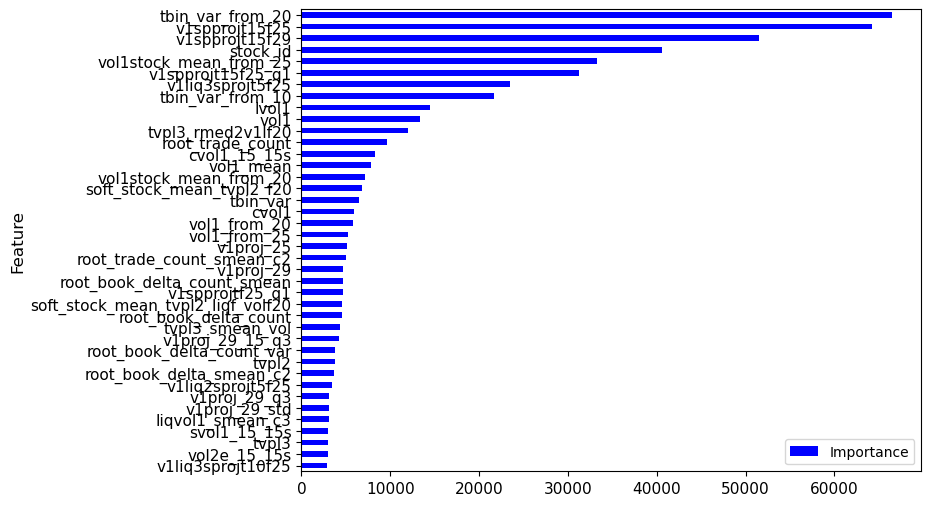

CLUSTER: 1 0.16965393115925134
model


/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.19799
[500]	valid_0's RMSPE: 0.19356
[750]	valid_0's RMSPE: 0.19249
[1000]	valid_0's RMSPE: 0.19212
[1250]	valid_0's RMSPE: 0.19203
[1500]	valid_0's RMSPE: 0.1921
Early stopping, best iteration is:
[1189]	valid_0's RMSPE: 0.19193
SCORE: 0.19193481586275524
0.5358035311520217
0.6123859422422595
0.9244102520867641
0.9338291741678064
model


/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.20225
[500]	valid_0's RMSPE: 0.19803
[750]	valid_0's RMSPE: 0.19675
[1000]	valid_0's RMSPE: 0.19629
[1250]	valid_0's RMSPE: 0.19607
[1500]	valid_0's RMSPE: 0.19602
[1750]	valid_0's RMSPE: 0.19598
[2000]	valid_0's RMSPE: 0.196
Early stopping, best iteration is:
[1556]	valid_0's RMSPE: 0.19597
SCORE: 0.19597475232801367
0.5376967192974325
0.5872348611866335
0.9189773859056674
0.9300920619379347
model


/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.20366
[500]	valid_0's RMSPE: 0.19943
[750]	valid_0's RMSPE: 0.19829
[1000]	valid_0's RMSPE: 0.19783
[1250]	valid_0's RMSPE: 0.19749
[1500]	valid_0's RMSPE: 0.19731
[1750]	valid_0's RMSPE: 0.19732
[2000]	valid_0's RMSPE: 0.19735
Early stopping, best iteration is:
[1687]	valid_0's RMSPE: 0.19729
SCORE: 0.19729318959940156
0.5582884666767025
0.604146516575591
0.9240563208192507
0.9319199977681152
model


/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.20203
[500]	valid_0's RMSPE: 0.19788
[750]	valid_0's RMSPE: 0.19683
[1000]	valid_0's RMSPE: 0.19652
[1250]	valid_0's RMSPE: 0.1966
[1500]	valid_0's RMSPE: 0.19664
Early stopping, best iteration is:
[1052]	valid_0's RMSPE: 0.19645
SCORE: 0.19645475474460328
0.47491554300703087
0.5841007171097805
0.92068074836119
0.9292188176890726


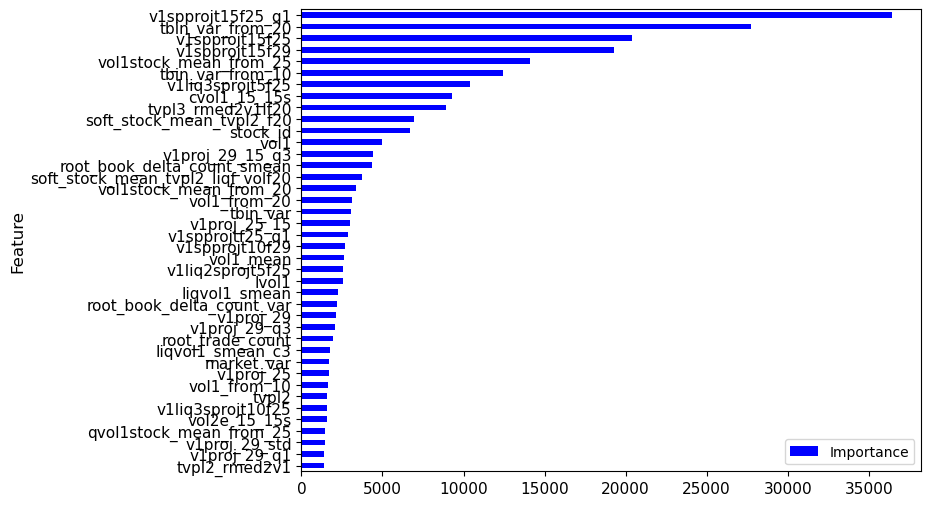

CLUSTER: 2 0.285695634739306
model


/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.22054
[500]	valid_0's RMSPE: 0.21553
[750]	valid_0's RMSPE: 0.21438
[1000]	valid_0's RMSPE: 0.214
[1250]	valid_0's RMSPE: 0.21376
[1500]	valid_0's RMSPE: 0.21377
Early stopping, best iteration is:
[1174]	valid_0's RMSPE: 0.21373
SCORE: 0.2137323059795213
0.5684647543224527
0.6396043734717877
0.9285565236125005
0.9337867309895673
model


/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.21869
[500]	valid_0's RMSPE: 0.21391
[750]	valid_0's RMSPE: 0.2126
[1000]	valid_0's RMSPE: 0.21204
[1250]	valid_0's RMSPE: 0.21177
[1500]	valid_0's RMSPE: 0.2117
[1750]	valid_0's RMSPE: 0.21172
[2000]	valid_0's RMSPE: 0.21172
Early stopping, best iteration is:
[1595]	valid_0's RMSPE: 0.21166
SCORE: 0.2116635057300581
0.5407438333755324
0.6235314865404833
0.9217868887100074
0.9329567792972508
model


/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.22103
[500]	valid_0's RMSPE: 0.2164
[750]	valid_0's RMSPE: 0.21543
[1000]	valid_0's RMSPE: 0.21511
[1250]	valid_0's RMSPE: 0.21499
[1500]	valid_0's RMSPE: 0.21505
[1750]	valid_0's RMSPE: 0.21513
Early stopping, best iteration is:
[1363]	valid_0's RMSPE: 0.21497
SCORE: 0.21497451415091356
0.5251875752633478
0.6381735046979121
0.9184279875484728
0.9344739824569733
model


/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.21929
[500]	valid_0's RMSPE: 0.21566
[750]	valid_0's RMSPE: 0.2146
[1000]	valid_0's RMSPE: 0.21429
[1250]	valid_0's RMSPE: 0.21426
[1500]	valid_0's RMSPE: 0.21428
[1750]	valid_0's RMSPE: 0.21437
Early stopping, best iteration is:
[1306]	valid_0's RMSPE: 0.21422
SCORE: 0.21422472898300143
0.5453621096258939
0.6135656382828556
0.9243303527406034
0.9312909558793717


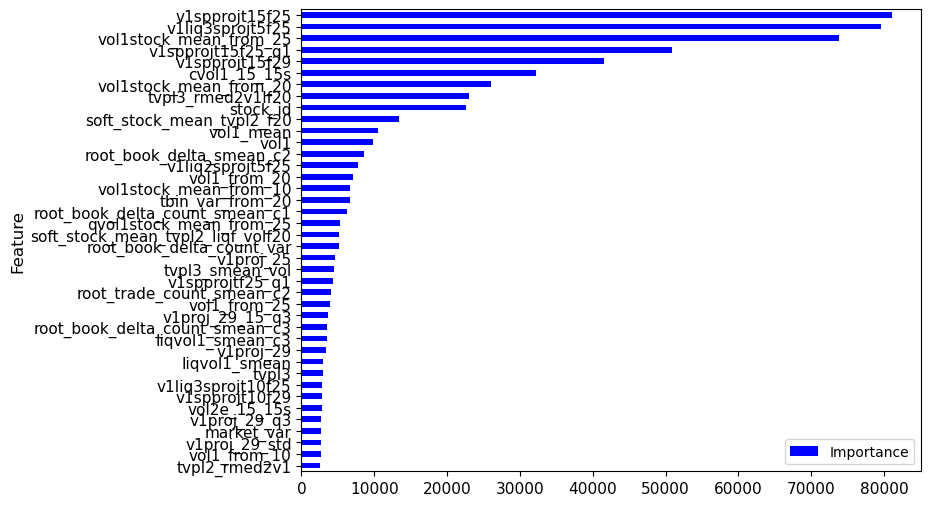

CLUSTER: 3 0.22322652541661617
model


/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.22805
[500]	valid_0's RMSPE: 0.22369
[750]	valid_0's RMSPE: 0.22327
[1000]	valid_0's RMSPE: 0.22458
Early stopping, best iteration is:
[700]	valid_0's RMSPE: 0.22321
SCORE: 0.22320843537233773
0.4571688193411518
0.5729721248819003
0.9299759378803945
0.9347796761740728
model


/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.23579
[500]	valid_0's RMSPE: 0.2305
[750]	valid_0's RMSPE: 0.22965
[1000]	valid_0's RMSPE: 0.22938
[1250]	valid_0's RMSPE: 0.22982
Early stopping, best iteration is:
[903]	valid_0's RMSPE: 0.22915
SCORE: 0.22915198024358574
0.3798303952269713
0.548433736977354
0.9219863497993832
0.9305843316259452
model


/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.22831
[500]	valid_0's RMSPE: 0.22351
[750]	valid_0's RMSPE: 0.22226
[1000]	valid_0's RMSPE: 0.22189
[1250]	valid_0's RMSPE: 0.2219
[1500]	valid_0's RMSPE: 0.22195
Early stopping, best iteration is:
[1129]	valid_0's RMSPE: 0.22179
SCORE: 0.22179203614596132
0.5125374377798639
0.5863546482708885
0.9327959276697386
0.9376130475142476
model


/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.25362
[500]	valid_0's RMSPE: 0.24705
[750]	valid_0's RMSPE: 0.24752
[1000]	valid_0's RMSPE: 0.24905
Early stopping, best iteration is:
[584]	valid_0's RMSPE: 0.24663
SCORE: 0.24663438848315433
0.4244513695081798
0.5428722225021365
0.9244965649909239
0.9310984348986853


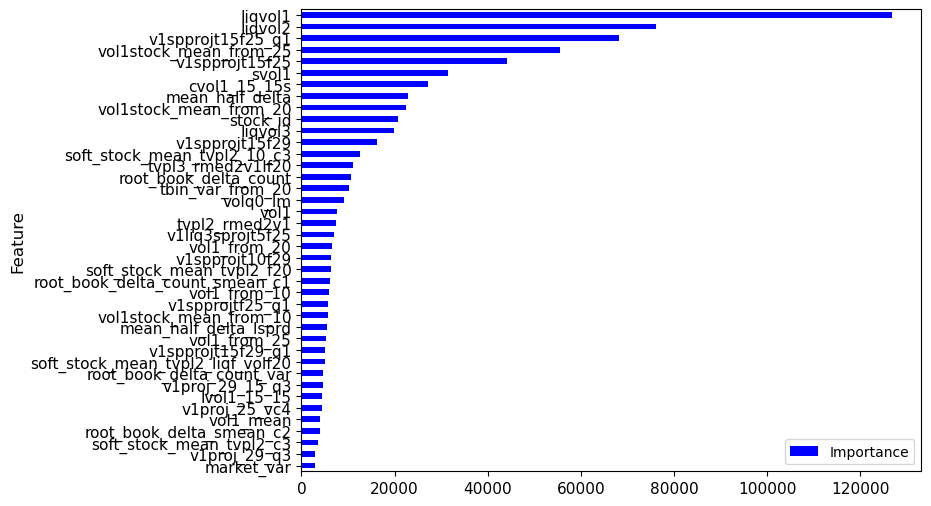

FULL SCORE: 0.21438686174779067


In [8]:
from sklearn.model_selection import KFold


model_name = 'lgbmodel'
pred_name ='lgbpred'

def feval_RMSPE(preds, train_data):
    labels = train_data.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds),5), False

def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

seed1=11


params_lgbm = {
        'learning_rate': 0.01,        
        'lambda_l1': 4,
        'lambda_l2': 7,
        'num_leaves': 800,
        'min_sum_hessian_in_leaf': 20,
        'feature_fraction': 0.8,
        'feature_fraction_bynode': 0.8,
        'bagging_fraction': 0.9,
        'bagging_freq': 42,
        'min_data_in_leaf': 256,
        'max_depth': 8,
        'objective': 'regression',
        'metric': 'None',
    
        'seed': seed1,
        'feature_fraction_seed': seed1,
        'bagging_seed': seed1,
        'drop_seed': seed1,
        'data_random_seed': seed1,
        'boosting': 'gbdt',
        'verbosity': -1,
        'n_jobs':-1,
    }


cats=['stock_id']


features_to_consider = features + cats   
features_to_consider = list(np.unique(features_to_consider))

#test_df['target'] = 0.0

    
gc.collect()
    
n_folds = 4
n_rounds = 5000
kf = model_selection.KFold(n_splits=n_folds, shuffle=False)
scores_folds[model_name] = []
counter = 1

u = np.unique(train['time_id'])


all_models= []

comb_importances = []

cluster_importances = {}

cluster_key= 'lr1_clusters2'
full_score = 0.0
for cluster in range(np.max(train_df[cluster_key])+1):
    models = []

    print('CLUSTER:', cluster, np.mean(train_df[cluster_key]==cluster))
    
    train_cluster = train_df.loc[train_df[cluster_key]==cluster].reset_index(drop=True)
    
    kf = KFold(4)
    
    for ttids, vtids in kf.split(u):
        
        train_batch = train_cluster.loc[train_cluster['time_id'].isin(u[ttids])].reset_index(drop=True)
        val_batch   = train_cluster.loc[train_cluster['time_id'].isin(u[vtids])].reset_index(drop=True)

        
        v1t = np.exp(train_batch['vol1'])
        v1v = np.exp(  val_batch['vol1'])

        X_train = train_batch[features_to_consider]
        y_train = train_batch['target'].values
        w_train = train_batch['target'].values **-2 * v1t**2

        X_val = val_batch[features_to_consider]
        y_val = val_batch['target'].values
        w_val = val_batch['target'].values **-2 * v1v**2


        train_data = lgb.Dataset(X_train, label=y_train/v1t, categorical_feature=cats, weight=w_train)
        val_data   = lgb.Dataset(X_val,   label=  y_val/v1v,   categorical_feature=cats, weight=w_val  )



        print('model')
        model = lgb.train(params_lgbm, 
                          train_data, 
                          n_rounds, 
                          valid_sets=val_data, 
                          feval=feval_RMSPE,

                        #   verbose_eval= 250,
                        #   early_stopping_rounds=500,
                          callbacks=[lgb.early_stopping(stopping_rounds=500), lgb.log_evaluation(period=250)])

        models.append(model)
        all_models.append(model)

        p = model.predict(X_val)*v1v
        score =  np.mean( ((p-y_val)/y_val)**2 )**0.5
        
        full_score += y_val.shape[0]*score**2
        
        
        print('SCORE:', score)
        print(nancorr(       p/v1v ,        y_val/v1v ))
        print(nancorr(np.log(p/v1v), np.log(y_val/v1v)))

        print(nancorr(p, y_val))
        print(nancorr(np.log(p), np.log(y_val)))

        
        #test_pred = (model.predict(test_df[features_to_consider][test_df[cluster_key]==cluster] )
        #                                                         *np.exp(test_df['vol1'][test_df[cluster_key]==cluster]) )
        
        #test_df['target'][test_df[cluster_key]==cluster] += test_pred/n_folds


        counter += 1



    importances = pd.DataFrame({'Feature': model.feature_name(), 
                                'Importance': sum( [model.feature_importance(importance_type='gain') for model in models] )})

    cluster_importances[cluster] = importances
    

    importances2 = importances.nlargest(40,'Importance', keep='first').sort_values(by='Importance', ascending=True)
    importances2[['Importance', 'Feature']].plot(kind = 'barh', x = 'Feature', figsize = (8,6), color = 'blue', fontsize=11);plt.ylabel('Feature', fontsize=12)
    plt.show()

    
lgbm_importances = pd.DataFrame({'Feature': model.feature_name(), 
                                'Importance': sum( [model.feature_importance(importance_type='gain') for model in all_models] )})
    
del models, all_models
    
    

def importance(feature):
    return importances[importances['Feature'] == feature]

full_score = ( full_score / train_df.shape[0] )**0.5

print('FULL SCORE:', full_score)


## NN Model

In [7]:
###### https://bignerdranch.com/blog/implementing-swish-activation-function-in-keras/
import tensorflow as tf
from keras.backend import sigmoid



def swish(x, beta = 1, extrapolation=.667):
    q = (x**2+1)**.5
    qq = q**(1-extrapolation)

    return tf.concat( ( x/qq * (x/q + 1)/2, -x/qq * (-x/q + 1)/2,    x, qq/q),  -1)


from keras import backend as K

from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish': Activation(swish)})



def root_mean_squared_per_error(y_true, y_pred):
    return K.sqrt(K.mean( tf.cast(y_true>0,tf.float32) * K.square( (y_true - y_pred)/ (y_true+1e-10))) )
    

stock_embedding_size = 12

cat_data = train['stock_id']

def base_model(n_sids, n_features):
    
    
    stock_embedding_size = 4

    
    stock_id_input = keras.Input(shape=(n_sids,), name='stock_id')

    num_input = keras.Input(shape=(n_sids, n_features), name='num_data')


    x = num_input
    
    xm = tf.math.reduce_mean(x, axis=(0), keepdims=True)
    xs = tf.math.reduce_std( x, axis=(0), keepdims=True)
                            

                            
    x = x - xm
    x = x / (xs + 1e-12)
    
    xs = keras.layers.Concatenate()((xm, xs)) 
    xs = keras.layers.Dense(16)(xs)
    x = keras.layers.Concatenate()((x, xs + 0*x[:,:,:1])) 
    
    
    
    stock_embedded = keras.layers.Embedding(max(cat_data)+1, stock_embedding_size, 
                                           input_length=1, name='stock_embedding')(stock_id_input)


    x = keras.layers.GaussianNoise(.05)(x)
    x = keras.layers.Concatenate()([stock_embedded, x])

        

    hidden_units = ( 256,128,64,32)
    extrapolations = (.75, .75, .6, .45, .45)
    dropouts = (0.15, 0.00, 0.0, 0., 0.)
    
    
    for k in range(len(hidden_units)):
        x = keras.layers.Dense(hidden_units[k], activation='linear')(x)
        if dropouts[k] > 0:
            x = keras.layers.Dropout(dropouts[k])(x)
        x = swish(x, beta=1, extrapolation= extrapolations[k])
    
    q = keras.layers.Dense(16)(x)
    
    q = tf.transpose(q, [0,2,1])
    q = keras.layers.SpatialDropout1D(.25)(q)
    q = tf.transpose(q, [0,2,1])
 
    q = swish(q, extrapolation=0.85)

    
    q = keras.layers.Flatten()(q)
        
    q = keras.layers.Dense(64)(q)
    q = keras.layers.Dropout(.25)(q)  
    q = swish(q, beta=1)
    
    
    q = keras.layers.Dense(32)(q)
    q = swish(q, beta=1,extrapolation=.6)
    
    
    q = keras.layers.Dense(n_sids)(q)
    q = keras.layers.Reshape([n_sids, 1])(q)
    

    out = keras.layers.Dense(1, activation='linear', name='prediction')(x) +  q
    
        
    model = keras.Model(
    inputs = [stock_id_input,  num_input],
    outputs = out,
    )
    
    return model

In [8]:
def low_reg_model(n_sids, n_features):
    
    # Each instance will consist of two inputs: a single user id, and a single movie id
    
    stock_embedding_size = 4

    
    stock_id_input = keras.Input(shape=(n_sids,), name='stock_id')

    num_input = keras.Input(shape=(n_sids, n_features), name='num_data')

    x = num_input

    
    xm = tf.math.reduce_mean(x, axis=(0), keepdims=True)
    xs = tf.math.reduce_std( x, axis=(0), keepdims=True)
                                                        
    x = x - xm
    x = x / (xs + 1e-12)
    
    xs = keras.layers.Concatenate()((xm, xs)) 
    xs = keras.layers.Dense(16)(xs)
    x = keras.layers.Concatenate()((x, xs + 0*x[:,:,:1])) 
    
    
    stock_embedded = keras.layers.Embedding(max(cat_data)+1, stock_embedding_size, 
                                           input_length=1, name='stock_embedding')(stock_id_input)


    x = keras.layers.GaussianNoise(.05)(x)

    
    x = keras.layers.Concatenate()([stock_embedded, x])

        

    hidden_units = ( 256,128,64,32)
    extrapolations = (.75, .75, .6, .45, )
    dropouts = (0.25, 0.0, 0.0, 0.0,)
    
    
    for k in range(len(hidden_units)):
        x = keras.layers.Dense(hidden_units[k], activation='linear')(x)
        if dropouts[k] > 0:
            x = keras.layers.Dropout(dropouts[k])(x)
        x = swish(x, beta=1, extrapolation= extrapolations[k])
        
    
    
    q = keras.layers.Dense(16)(x)
    
    q = tf.transpose(q, [0,2,1])
    q = keras.layers.SpatialDropout1D(.25)(q)
    q = tf.transpose(q, [0,2,1])
 
    q = swish(q, extrapolation=0.85)

    
    q = keras.layers.Flatten()(q)
    
    
    q = keras.layers.Dense(64)(q)
    q = keras.layers.Dropout(.25)(q)  
    q = swish(q, beta=1)
    
    
    q = keras.layers.Dense(32)(q)
    q = swish(q, beta=1,extrapolation=.6)
    
    
    q = keras.layers.Dense(n_sids)(q)
    q = keras.layers.Reshape([n_sids, 1])(q)
    

    out = keras.layers.Dense(1, activation='linear', name='prediction')(x) +  q
        
    model = keras.Model(
    inputs = [stock_id_input,  num_input],
    outputs = out,
    )
    
    return model

## Training

In [9]:
from sklearn import preprocessing, model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

def set_field_from_dict(fdict, df, field_name):

    T = fdict['time_ids']
    S = fdict['stock_ids']
    R = fdict[field_name]
    
    R = np.reshape( R, [R.shape[0]*R.shape[1]] )
    S = np.reshape( S, [S.shape[0]*S.shape[1]] )
    T = np.reshape( T, [T.shape[0]*T.shape[1]] )

    dfz = pd.DataFrame(data=np.vstack([S,T,R]  ).T, columns=['stock_id', 'time_id',field_name])

    dfz['time_id' ] = dfz['time_id' ].astype(int)
    dfz['stock_id'] = dfz['stock_id'].astype(int)

    dfz = df.merge(dfz, on=['stock_id', 'time_id'], how='left')
    return dfz

def rmspe(y_true, y_pred):
    return  np.sqrt(np.mean((y_true>0)*np.square((y_true - y_pred) / (y_true+1e-10) )))


es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=25, verbose=0,
    mode='min',restore_best_weights=False)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.15, patience=8, verbose=0,
    mode='min')

model_name = 'full_model'
pred_name = model_name + '_pred'

gc.collect()
    
n_folds = 4
    
X_test = keys_to_array(test_feat, features)
X_test[np.isnan(X_test)] = 0
X_test[X_test<-10000] = -10000
X_test[X_test> 10000] =  10000
    
v_test = np.exp(test_feat['vol1'])
S_test = test_feat['stock_ids']  

test_feat[pred_name] = 0*v_test
                               
    
    
X = keys_to_array(train_feat, features)

full_score=0
kf = KFold(n_folds)
for ti,vi in kf.split(X):
    
        
    X_train = X[ti,:,:]
    v_train = np.exp(train_feat['vol1'][ti,:,:])
    S_train = train_feat['stock_ids'][ti,:,:]   
    y_train = train_feat['target'][ti,:]
    
    X_val = X[vi,:,:]
    v_val = np.exp(train_feat['vol1'][vi,:,:])
    S_val = train_feat['stock_ids'][vi,:,:]   
    y_val = train_feat['target'][vi,:]

    
    X_train[np.isnan(X_train)] = 0
    X_val[  np.isnan(X_val)  ] = 0
    
    X_train[X_train<-10000] = -10000
    X_val[  X_val  <-10000] = -10000
    
    X_train[X_train>10000] = 10000
    X_val[  X_val  >10000] = 10000

 
    
    Xm = np.median(    X_train, axis=(0,1), keepdims=True)
    Xs = (np.quantile( X_train, .84, axis=(0,1), keepdims=True) - np.quantile( X_train, .16, axis=(0,1), keepdims=True))/2 + 1e-8
    
    ym = np.median(    np.log(y_train + 1e-12),      axis=(0,1), keepdims=True)
    ys = (np.quantile( np.log(y_train + 1e-12), .84, axis=(0,1), keepdims=True) - np.quantile( np.log(y_train), .16, axis=(0,1), keepdims=True))/2 + 1e-8
    
    
    
    X_train = (X_train - Xm)/Xs
    X_val   = (X_val   - Xm)/Xs
    
    X_train = np.tanh(X_train/5)*5
    X_val   = np.tanh(X_val  /5)*5
 
    model1= base_model(X_train.shape[1], X_train.shape[2])
    
    model1.compile(
        keras.optimizers.RMSprop(learning_rate=0.005, rho=.9),

        loss=root_mean_squared_per_error
    )
        
    
    model1.fit([S_train, X_train], 
              y_train[:,:,np.newaxis]/v_train,               
              batch_size=64,
              epochs=300, 
              validation_data=([S_val, X_val], y_val[:,:,np.newaxis]/v_val),
              callbacks=[es, plateau],
              validation_batch_size=y_val.shape[0],
              shuffle=True,
             verbose = 2)
 
   
    preds = (model1.predict([S_val,  X_val], batch_size=X_val.shape[0]))
    
    
    
    score = rmspe(y_val[:,:,np.newaxis], preds*v_val)
   
    full_score += score**2

    print('SCORE:', score)
    

    test_pred = (model1.predict([ S_test,  np.tanh((X_test - Xm)/Xs/5)*5], batch_size=X_test.shape[0]) )*v_test

    test_feat[pred_name] = test_feat[pred_name] + test_pred/n_folds
    
    gc.collect()
    
full_score = (full_score/n_folds)**0.5

print('FULL SCORE', full_score)




if IS_GOOD_TEST:
    test       = set_field_from_dict(test_feat,       test, pred_name)
else:
    dummy_test = set_field_from_dict(test_feat, dummy_test, pred_name)
    



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in log


Epoch 1/300
45/45 - 21s - loss: 8.7888 - val_loss: 1.3101
Epoch 2/300
45/45 - 14s - loss: 1.5659 - val_loss: 1.2618
Epoch 3/300
45/45 - 14s - loss: 1.0470 - val_loss: 1.3486
Epoch 4/300
45/45 - 13s - loss: 0.9687 - val_loss: 0.4919
Epoch 5/300
45/45 - 14s - loss: 0.7491 - val_loss: 0.5907
Epoch 6/300
45/45 - 14s - loss: 0.9279 - val_loss: 0.4010
Epoch 7/300
45/45 - 14s - loss: 0.6506 - val_loss: 0.2989
Epoch 8/300
45/45 - 14s - loss: 0.6752 - val_loss: 0.3789
Epoch 9/300
45/45 - 13s - loss: 1.0162 - val_loss: 0.3194
Epoch 10/300
45/45 - 14s - loss: 0.5944 - val_loss: 0.4577
Epoch 11/300
45/45 - 13s - loss: 1.3477 - val_loss: 0.3186
Epoch 12/300
45/45 - 13s - loss: 1.3695 - val_loss: 0.5117
Epoch 13/300
45/45 - 14s - loss: 0.3982 - val_loss: 0.3508
Epoch 14/300
45/45 - 13s - loss: 0.7963 - val_loss: 0.3097
Epoch 15/300
45/45 - 14s - loss: 1.3116 - val_loss: 0.3020
Epoch 16/300
45/45 - 13s - loss: 0.2434 - val_loss: 0.2552
Epoch 17/300
45/45 - 13s - loss: 0.2390 - val_loss: 0.2448
Epoch 

In [10]:
model_name = 'select_model'

pred_name = model_name + '_pred'

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, verbose=0,
    mode='min',restore_best_weights=True)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.15, patience=7, verbose=0,
    mode='min')

gc.collect()
    
n_folds = 4
kf = model_selection.KFold(n_splits=n_folds, shuffle=False)
counter = 1


select_features = lgbm_importances.nlargest(40,'Importance', keep='first').sort_values(by='Importance', ascending=True)
select_features = list(select_features['Feature'])
select_features.remove('stock_id')
    

X_test = keys_to_array(test_feat, select_features)
X_test[np.isnan(X_test)] = 0
X_test[X_test<-10000] = -10000
X_test[X_test> 10000] =  10000
    
v_test = np.exp(test_feat['vol1'])
S_test = test_feat['stock_ids']  
test_feat[pred_name] = 0*v_test
                       
                               
X = keys_to_array(train_feat, select_features)

full_score=0
kf = KFold(n_folds)
for ti,vi in kf.split(X):
    
    print(ti.shape[0], vi.shape[0], X.shape[0])
        
    X_train = X[ti,:,:]
    v_train = np.exp(train_feat['vol1'][ti,:,:])
    S_train = train_feat['stock_ids'][ti,:,:]   
    y_train = train_feat['target'][ti,:]
    
    X_val = X[vi,:,:]
    v_val = np.exp(train_feat['vol1'][vi,:,:])
    S_val = train_feat['stock_ids'][vi,:,:]   
    y_val = train_feat['target'][vi,:]

    
    X_train[np.isnan(X_train)] = 0
    X_val[  np.isnan(X_val)  ] = 0
    
    X_train[X_train<-10000] = -10000
    X_val[  X_val  <-10000] = -10000
    
    X_train[X_train>10000] = 10000
    X_val[  X_val  >10000] = 10000

    
    Xm = np.median(    X_train,      axis=(0,1), keepdims=True)
    Xs = (np.quantile( X_train, .84, axis=(0,1), keepdims=True) - np.quantile( X_train, .16, axis=(0,1), keepdims=True))/2 + 1e-8
    
    ym = np.median(    np.log(y_train + 1e-12),      axis=(0,1), keepdims=True)
    ys = (np.quantile( np.log(y_train + 1e-12), .84, axis=(0,1), keepdims=True) - np.quantile( np.log(y_train), .16, axis=(0,1), keepdims=True))/2 + 1e-8
    
    
    X_train = (X_train - Xm)/Xs
    X_val   = (X_val   - Xm)/Xs
    
    X_train = np.tanh(X_train/5)*5
    X_val   = np.tanh(X_val  /5)*5


    
    model1= low_reg_model(X_train.shape[1], X_train.shape[2])
    
    model1.compile(
        keras.optimizers.RMSprop(learning_rate=0.005, rho=.9),

        loss=root_mean_squared_per_error
    )
        
    model1.fit([S_train, X_train], 
              y_train[:,:,np.newaxis]/v_train,               
              batch_size=64,
              epochs=200, 
              validation_data=([S_val, X_val], y_val[:,:,np.newaxis]/v_val),
              callbacks=[es, plateau],
              validation_batch_size=y_val.shape[0],
              shuffle=True,
             verbose = 2)
 
   
    preds = (model1.predict([S_val,  X_val], batch_size=X_val.shape[0]))
        
    score = rmspe(y_val[:,:,np.newaxis], preds*v_val)
   
    full_score += score**2

    print('SCORE:', score)
    

    test_pred = (model1.predict([ S_test,  np.tanh((X_test - Xm)/Xs/5)*5], batch_size=X_test.shape[0]) )*v_test


    
    test_feat[pred_name] = test_feat[pred_name] + test_pred/n_folds

    
    gc.collect()
    
full_score = (full_score/n_folds)**0.5

print('FULL SCORE', full_score)




if IS_GOOD_TEST:
    test = set_field_from_dict(test_feat, test, pred_name)
else:
    dummy_test = set_field_from_dict(test_feat, dummy_test, pred_name)
    
    
    
    
if IS_GOOD_TEST:
    test['target']       = 0.6*      test['full_model_pred'] + 0.4*      test['select_model_pred']
else:
    dummy_test['target'] = 0.6*dummy_test['full_model_pred'] + 0.4*dummy_test['select_model_pred']
  
    
    print(dummy_test)
    print(dummy_test.columns)
    comb_test = dummy_test.merge(train, on=['time_id','stock_id'], how='right')
    comb_test['target_y'] = 1.0*comb_test['target_y']
    
    print(comb_test.columns)
    
    print('TEST SCORE:', np.mean( (  (comb_test['target_x']-comb_test['target_y'])/comb_test['target_y']  )**2)**0.5)
    
    test['target'] = 0

    
    
    
test['row_id'] = test['stock_id'].astype(str) + '-' + test['time_id'].astype(str)

print(test)

test[['row_id', 'target']].to_csv('submission.csv',index = False)

2872 958 3830


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in log


Epoch 1/200
45/45 - 16s - loss: 8.1888 - val_loss: 1.5335
Epoch 2/200
45/45 - 12s - loss: 1.3774 - val_loss: 0.7833
Epoch 3/200
45/45 - 12s - loss: 1.2866 - val_loss: 0.6406
Epoch 4/200
45/45 - 12s - loss: 0.9431 - val_loss: 1.9396
Epoch 5/200
45/45 - 12s - loss: 0.9677 - val_loss: 1.2111
Epoch 6/200
45/45 - 12s - loss: 0.6571 - val_loss: 1.7100
Epoch 7/200
45/45 - 12s - loss: 0.9070 - val_loss: 0.8629
Epoch 8/200
45/45 - 12s - loss: 0.4664 - val_loss: 0.5828
Epoch 9/200
45/45 - 12s - loss: 0.8744 - val_loss: 0.8346
Epoch 10/200
45/45 - 12s - loss: 0.6102 - val_loss: 0.7575
Epoch 11/200
45/45 - 12s - loss: 0.9593 - val_loss: 1.6980
Epoch 12/200
45/45 - 12s - loss: 0.5057 - val_loss: 0.9005
Epoch 13/200
45/45 - 12s - loss: 0.9426 - val_loss: 0.6798
Epoch 14/200
45/45 - 12s - loss: 0.6876 - val_loss: 1.1597
Epoch 15/200
45/45 - 12s - loss: 0.7283 - val_loss: 0.7578
Epoch 16/200
45/45 - 12s - loss: 0.2946 - val_loss: 0.2711
Epoch 17/200
45/45 - 12s - loss: 0.2436 - val_loss: 0.2674
Epoch 